# Understanding Wfield Data
An overview of the stimulus and widefield computer file types and their attributes as well as alignment methods for the Trenholm Lab data.

*Last Update: March 20th 2025*

Files from the wfield computer
- Analog_#.dat
- Frames_#_ 640_540_uint16 _####.dat
- framesTimes_0001.mat
- handles.mat
- snapshot.png / .mat

Files from the stimulus computer
- data_test_LEDStimulus_###.hdf5
- data_test_LEDStimulus_###_mat.mat

**Analog File**: Contains experiment information such as stimulus TTL pulses, blue and violet LED pulses, experimental start time and more as timestamped by the widefield computer

**Frames_2_640_540...dat**: contains a stack of 640x540 frames as captured by the camera 
    - file name contains the channel number, frame size, and data type

**frameTimes_0001.mat**: time stamp for each frame 

**data_test_LEDStimulus**: contains similar data to the analog file but captured by the stimulus computer

Run all import statements

In [1]:
# Import all necessary modules

# widefield modules
from exploration_utils import *
from pipeline_utils import *
from processing import * 
from data_extractor import *

# general modules 
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import timedelta
import scipy.signal
import os

Modify the code below for your particular data 

In [2]:
# params are global variables used to modify the code below
EXPERIMENT_PATH = r"D:\wfield\NicoleData\WT\7203\LED_530_R_F0.5_ND1_FW2\08-Jan-2025"
STIM_TYPE = 'LED'      # 'OLFAC', 'LED', 'AUDIO'...
CAMERA_HZ = 40         # Acquistion Rate

# indicate whether this experiment is an alignment test experiment or not
IS_ALIGNMENT_TEST = False
ELAPSED_TIME =  58.007879   # time in seconds indicated by matlab following each trial.    **if none recorded, write None

The variables we'll create and explore in this notebook: 

|Frame Data (Analog comp)| Stim Computer Data | Analog Computer Data |
|:------------:|:------------:|:------------:|
|  blue_frames, violet_frames |  stim_time | analog_data  | 
|  blue_ftimes, violet_ftimes |  stim_configs| analog_experiment_start_timestamp |
| blue_darkFrame_num, violet_darkFrame_num |  stim_pulse_times  | |
| removed_frames |  stim_sync  | |  
| pre_post_stim |  stim_params   | | 
| stim_imgSize  |  stim_sync_scaling| | 
|   |  stim_experiment_start_timestamp *(in 'OLD' data only)* | | 
|  | tstim *(in 'NEW' data only)* | | 

Load all variables to be explored. Feel free to comment out those you do not need in order to save space and time.

*If no lines are commented, the cell takes about 1.5 minutes to run.*

In [3]:
# Code below determines whether the experiment has data_format "NEW" or "OLD". experiment made on or after FEB 12th 2025 == "NEW" else "OLD"
DATA_FORMAT = get_dataFormat_type(EXPERIMENT_PATH)

# Frame Data ---------------------------------------
frames = load_dat_frames(get_exp_file_path(EXPERIMENT_PATH, 'F'))
blue_darkFrame_num, violet_darkFrame_num = get_darkFrame_num(frames, threshold=0.3)
blue_frames = frames[:,0,:,:]
violet_frames = frames[:,1,:,:]
del frames

frameTimes, frameTime_dict = get_frameTime_data(get_exp_file_path(EXPERIMENT_PATH, 'T'), channel_num=2, returnType='datetime')
blue_fTimes = frameTimes[0]
violet_fTimes = frameTimes[1] 
removed_frames = frameTime_dict['removed_frames']
pre_post_stim = frameTime_dict['pre_post_stim']
stim_imgSize = frameTime_dict['stim_img_size']
del frameTimes, frameTime_dict

# Stim Computer Data -------------------------------
stim_time = get_stim_duration(EXPERIMENT_PATH, STIM_TYPE)
stim_data = scipy.io.loadmat(get_exp_file_path(EXPERIMENT_PATH, 'M'), simplify_cells=True)
stim_sync = stim_data['sync']
stim_sync_scaling = {'offset': stim_data['sync_scaling']['offset'], 'range': stim_data['sync_scaling']['range'], 'scale': stim_data['sync_scaling']['scale']}

if DATA_FORMAT == "OLD":
    stim_configs = pickle.loads(stim_data['configs'].tobytes())
    stim_experiment_start_timestamp = pickle.loads(stim_data['experiment_start_timestamp'].tobytes())      # this is no longer available as of 02-14-2025
    stim_stim_pulse_info = pickle.loads(stim_data['stimulus_frame_info'].tobytes())
    stim_pulse_times = np.array([datetime.datetime.fromtimestamp(frame_info['time']) for frame_info in stim_stim_pulse_info])
    stim_params = pickle.loads(stim_data['parameters'].tobytes())
elif DATA_FORMAT == "NEW":
    stim_configs = stim_data['configs']
    stim_stim_pulse_info = stim_data['stimulus_frame_info']
    if STIM_TYPE in ["LED", "AUDIO"]:
        stim_pulse_times = np.array([datetime.datetime.fromtimestamp(float(frame_info['time'])) for frame_info in stim_stim_pulse_info])
    elif STIM_TYPE == "OLFAC":
        stim_pulse_times = []
        stim_blockStart_times = []
        # there are three array entries per "stim"
        # the first has the start time and block start "index"
        # the second has the odorname but we do not need to store this here as it's already in the stim_configs['experiment_config']['DELIVERED_ODORS'] array
        # the third has the stop time (the block end has the same value as the block start)
        for i, _ in enumerate(stim_stim_pulse_info[0::3]):
            j = i * 3
            stim_pulse_times.append(datetime.datetime.fromtimestamp(float((stim_stim_pulse_info[j])['time']))) # start_time
            stim_blockStart_times.append((stim_stim_pulse_info[j])['block_start']) # block_start 
            stim_pulse_times.append(datetime.datetime.fromtimestamp(float((stim_stim_pulse_info[j+2])['time']))) # stop_time
        stim_pulse_times = np.array(stim_pulse_times)
    stim_params = stim_data['parameters']
    tstim = stim_data['tstim'] # addition as of 02-14-2025 

# Widefield Computer Data --------------------------
analog_data, analog_dict = load_dat_analog(get_exp_file_path(EXPERIMENT_PATH, 'A'))
analog_baseline = analog_dict['baseline']
analog_onset = mattime_to_hour(analog_dict['onset'])
analog_nChannels = analog_dict['nchannels']
analog_nSamples = analog_dict['nsamples']

## Frame data exploration *part one*

Let's first look into the shape of our data: both frames and frame times

*Notice how sometimes there is a discreptancy between frame # and frameTime #*

In [4]:
print(f"Total Frames as determined by: \n     - # of camera frames: {blue_frames.shape[0] + violet_frames.shape[0]}")
print(f"     - # of frame times: {blue_fTimes.shape[0] + violet_fTimes.shape[0]}")
print(f"     - stim computer ftimes imgSize variable: {stim_imgSize[-1]}\n")

print(f"blue_frames: \n     - frames array shape: {blue_frames.shape}\n     - frame_times array shape: {blue_fTimes.shape}")
print(f"\nviolet_frames: \n     - frames array shape: {violet_frames.shape}\n     - frame_times array shape: {violet_fTimes.shape}")

print(f"\n# of Pre stim frames (from stim fTimes.mat): {pre_post_stim[0]}")
print(f"# of Post stim frames (from stim fTimes.mat): {pre_post_stim[1]}")
print(f"# of removed frames (from stim fTimes.mat): {removed_frames}")
print(f"   {pre_post_stim[0]} + {pre_post_stim[1]} = {pre_post_stim[0]+pre_post_stim[1]}")

# for the rest of the notebook, take note of whether the number of camera frames is consistent with the number of frame times
CONSISTENT_FAME_NUM = (blue_frames.shape[0] + violet_frames.shape[0]) == (blue_fTimes.shape[0] + violet_fTimes.shape[0])
print(f'\nCONSISTENT_FRAME_NUM variable: {CONSISTENT_FAME_NUM}')

Total Frames as determined by: 
     - # of camera frames: 5102
     - # of frame times: 5102
     - stim computer ftimes imgSize variable: 5103

blue_frames: 
     - frames array shape: (2551, 640, 540)
     - frame_times array shape: (2551,)

violet_frames: 
     - frames array shape: (2551, 640, 540)
     - frame_times array shape: (2551,)

# of Pre stim frames (from stim fTimes.mat): 80
# of Post stim frames (from stim fTimes.mat): 5023
# of removed frames (from stim fTimes.mat): 36
   80 + 5023 = 5103

CONSISTENT_FRAME_NUM variable: True


One way to visualize all frames together is by plotting the average pixel value per frame. 

***Dark frames***: According to the matlab output, there should be 5 dark frames at the end of each channel. In practice, this is not always the case for either channel. 

*NOTE: Uncomment `%matplotlib inline` to visualize the plots within the notebook. You will lose the ability to zoom into the graphs but you will be able to reference back to the plots without having to rerun a given cell.*

In [5]:
# to go back to out of line visualization, comment the line below and restart the kernel. 
%matplotlib inline
#%matplotlib qt


There are 2551 dark blue frames at the end of the experiment
There are 2551 dark violet frames at the end of the experiment


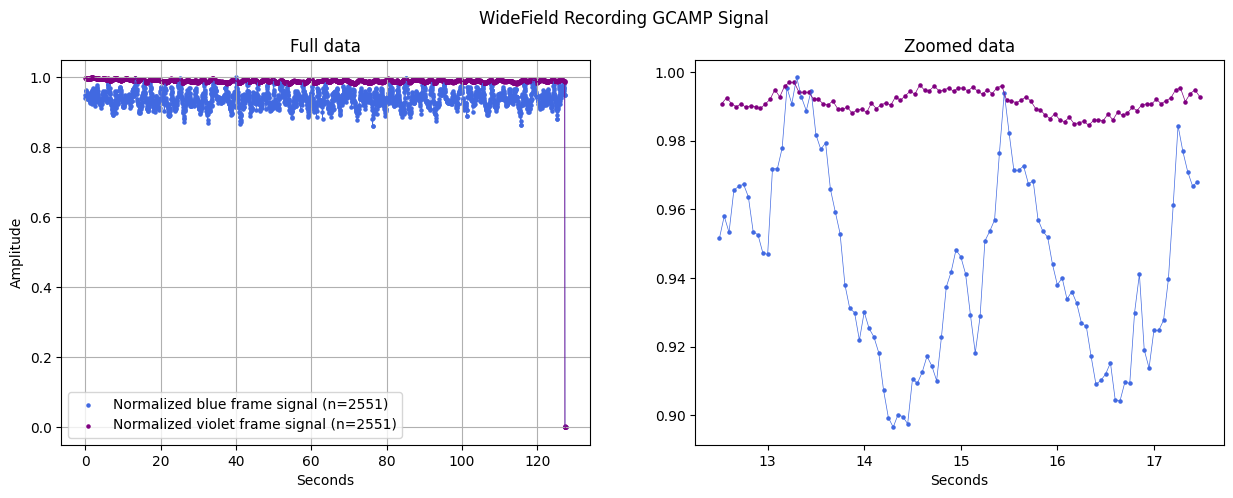

First frame is blue: 2025-01-08 17:00:47.174240
Last frame is violet: 2025-01-08 17:02:54.794117


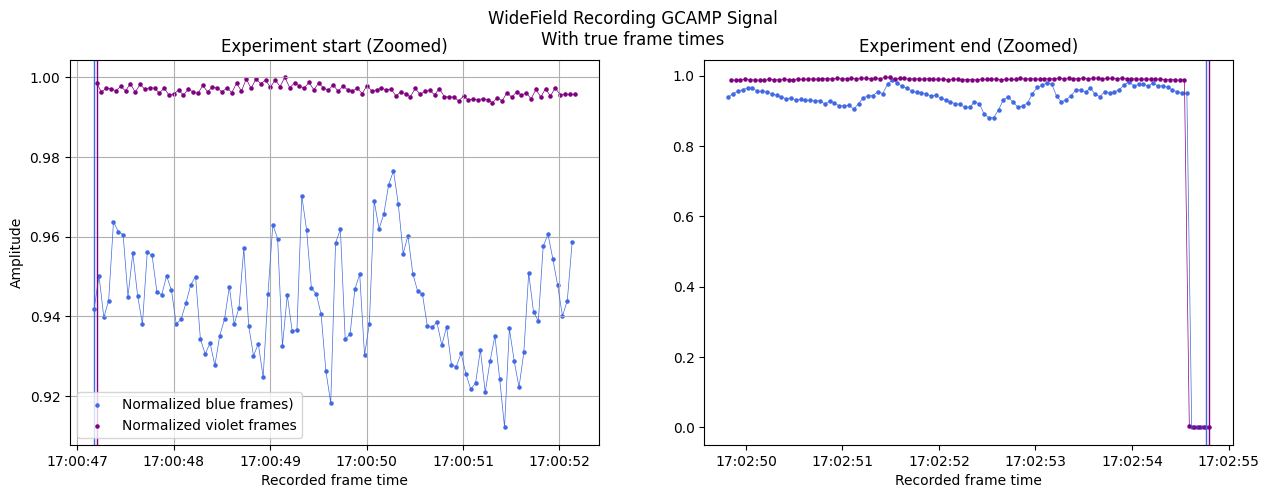

In [6]:
# Calculating a signal over the images
normalized_blue_mean = normalize_arr(np.mean(blue_frames,axis=(1,2)))
normalized_violet_mean = normalize_arr(np.mean(violet_frames, axis=(1,2)))

# determine how many "dark" (black) frames are present in each channel at the end of the recording
print(f"\nThere are {blue_darkFrame_num} dark blue frames at the end of the experiment")
print(f"There are {violet_darkFrame_num} dark violet frames at the end of the experiment")

frame_x_signal = np.arange(0, len(normalized_blue_mean)) / 20 # since 40 Hz is the camera but each channel has frames captured at 20Hz 

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle(f"WideField Recording GCAMP Signal")

axes[0].scatter(frame_x_signal, normalized_blue_mean, s=5, color = 'royalblue', label=f"Normalized blue frame signal (n={len(normalized_blue_mean)})")
axes[0].plot(frame_x_signal, normalized_blue_mean, linewidth=0.5, color = 'royalblue')

axes[0].scatter(frame_x_signal+1/40, normalized_violet_mean, s=5, color = 'purple', label=f"Normalized violet frame signal (n={len(normalized_violet_mean)})")
axes[0].plot(frame_x_signal+1/40, normalized_violet_mean, linewidth=0.5, color = 'purple')

axes[0].set_title(f'Full data')
axes[0].set_xlabel('Seconds')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid()

axes[1].scatter(frame_x_signal[250:350], normalized_blue_mean[250:350], s=5, color = 'royalblue', label=f"Normalized blue frame signal (n={len(normalized_blue_mean)})")
axes[1].plot(frame_x_signal[250:350], normalized_blue_mean[250:350], linewidth=0.5, color = 'royalblue')

axes[1].scatter((frame_x_signal+1/40)[250:350], normalized_violet_mean[250:350], s=5, color = 'purple', label=f"Normalized violet frame signal (n={len(normalized_violet_mean)})")
axes[1].plot((frame_x_signal+1/40)[250:350], normalized_violet_mean[250:350], linewidth=0.5, color = 'purple')

axes[1].set_title(f'Zoomed data')
axes[1].set_xlabel('Seconds')
plt.show()

# we can also plot the frames with xvalues = their corresponding frameTime
# plotting "True" frame times with average frame values 

if not CONSISTENT_FAME_NUM: # there is one less blue frame than blue frameTimes
    blue_fTimes = blue_fTimes[:-1]

print(f"First frame is blue: {blue_fTimes[0]}") if blue_fTimes[0] < violet_fTimes[0] else print(f"First frame is violet: {violet_fTimes[0]}")
print(f"Last frame is blue: {blue_fTimes[-1]}") if blue_fTimes[-1] > violet_fTimes[-1] else print(f"Last frame is violet: {violet_fTimes[-1]}")

# -------------------------------- #

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle(f"WideField Recording GCAMP Signal\nWith true frame times")

axes[0].scatter(blue_fTimes[:100], normalized_blue_mean[:100], s=5, color = 'royalblue', label=f"Normalized blue frames)")
axes[0].plot(blue_fTimes[:100], normalized_blue_mean[:100], linewidth=0.5, color = 'royalblue')

axes[0].scatter(violet_fTimes[:100], normalized_violet_mean[:100], s=5, color = 'purple', label=f"Normalized violet frames")
axes[0].plot(violet_fTimes[:100], normalized_violet_mean[:100], linewidth=0.5, color = 'purple')

axes[0].set_title(f'Experiment start (Zoomed)')
axes[0].set_xlabel('Recorded frame time')
axes[0].set_ylabel('Amplitude')
axes[0].axvline(x=blue_fTimes[0], color='royalblue', linewidth=1)  
axes[0].axvline(x=violet_fTimes[0], color='purple', linewidth=1)  

axes[0].legend()
axes[0].grid()

axes[1].scatter(blue_fTimes[-100:], normalized_blue_mean[-100:], s=5, color = 'royalblue', label=f"Normalized blue frame signal (n={len(normalized_blue_mean)})")
axes[1].plot(blue_fTimes[-100:], normalized_blue_mean[-100:], linewidth=0.5, color = 'royalblue')

axes[1].scatter(violet_fTimes[-100:], normalized_violet_mean[-100:], s=5, color = 'purple', label=f"Normalized violet frame signal (n={len(normalized_violet_mean)})")
axes[1].plot(violet_fTimes[-100:], normalized_violet_mean[-100:], linewidth=0.5, color = 'purple')
axes[1].axvline(x=blue_fTimes[-1], color='royalblue', linewidth=1)  
axes[1].axvline(x=violet_fTimes[-1], color='purple', linewidth=1)  

axes[1].set_title(f'Experiment end (Zoomed)')
axes[1].set_xlabel('Recorded frame time')
plt.show()

We can now explore the distance in time between frames

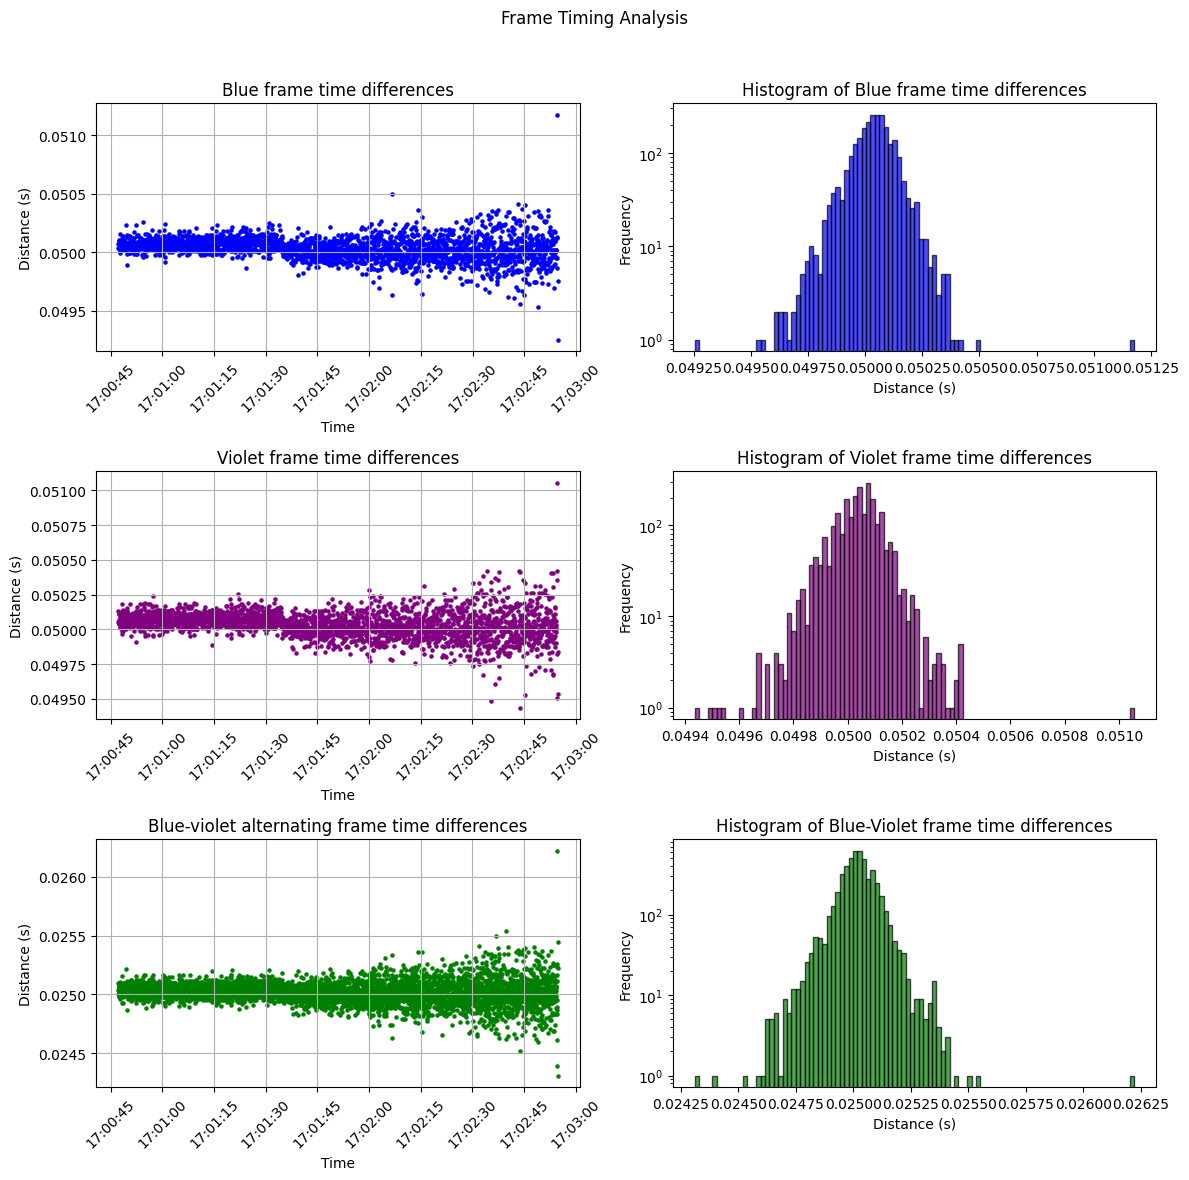

In [7]:
# Calculate distances in seconds between consecutive frames
blue_distances_d = (blue_fTimes[1:] - blue_fTimes[:-1])
blue_distances = np.array([delta.total_seconds() for delta in blue_distances_d])
violet_distances_d = (violet_fTimes[1:] - violet_fTimes[:-1])
violet_distances = np.array([delta.total_seconds() for delta in violet_distances_d])

# Interleave blue and violet times to calculate alternating distances
interleaved_times = np.sort(np.concatenate([blue_fTimes, violet_fTimes]))
interleaved_distances_d = (interleaved_times[1:] - interleaved_times[:-1])
interleaved_distances = np.array([delta.total_seconds() for delta in interleaved_distances_d])

# Create the figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle("Frame Timing Analysis")

# 1. Scatter plot: blue distances
axes[0, 0].scatter(blue_fTimes[:-1], blue_distances, s=5, color='blue')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Distance (s)')
axes[0, 0].set_title("Blue frame time differences")
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0,0].grid()

# 2. Scatter plot: violet distances
axes[1, 0].scatter(violet_fTimes[:-1], violet_distances, s=5, color='purple')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Distance (s)')
axes[1, 0].set_title("Violet frame time differences")
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1,0].grid()

# 3. Histogram: blue distances
axes[0, 1].hist(blue_distances, color='blue', bins=100, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Distance (s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Histogram of Blue frame time differences')

# 4. Histogram: violet distances
axes[1, 1].hist(violet_distances, bins=100, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Distance (s)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Histogram of Violet frame time differences')

# 5. Scatter plot: interleaved distances (blue and violet alternating)
axes[2, 0].scatter(interleaved_times[:-1], interleaved_distances, s=5,color='green')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('Distance (s)')
axes[2, 0].set_title("Blue-violet alternating frame time differences")
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].grid()

# 6. Histogram: interleaved distances
axes[2, 1].hist(interleaved_distances, bins=100, color='green', alpha=0.7, edgecolor='black')
axes[2, 1].set_xlabel('Distance (s)')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].set_title('Histogram of Blue-Violet frame time differences')
axes[2, 1].set_yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


## Analog file data exploration

This .dat file contains 
1. the blue LED TTL pulse signals (for calcium indicator activation)
2. the violet LED TTL pulse signals (for hemocorrection)
3. experimental start signal (as received by the analog computer)
4. experimental LED TTL pulse signals (as received by the analog computer) 
5. baseline value and onset time (in matlab time)

Analog onset: 2025-01-08 17:00:46.066682
Baseline value: 3.0
The rising edge index of the 'wf received exp start' pulse is 3097
This occurs at 3.097 seconds, as indicated by the above 'baseline' variable


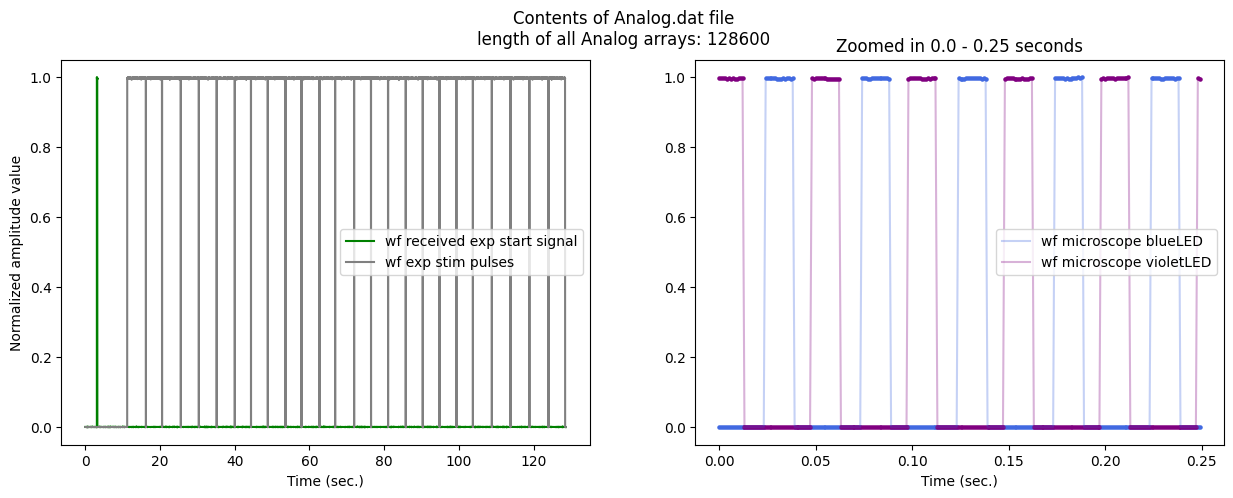

In [8]:
# Explore Analog.dat file

mpl.rcParams['agg.path.chunksize'] = 100000

straight_line = normalize_arr(analog_data[0])               # this is contained in the file but does not contain useful information (as of 02-11-2025)
wf_m_blueLED = normalize_arr(analog_data[1])
wf_m_violetLED = normalize_arr(analog_data[2])
wf_received_exp_start = normalize_arr(analog_data[3])
wf_exp_stim_pulses = normalize_arr(analog_data[4])

analog_x_values = np.arange(len(wf_m_blueLED)) / 1000 # display time in seconds 

print(f"Analog onset: {analog_onset}")
print(f"Baseline value: {analog_baseline}")
# we can also determine the index of the rising edge of the 'wf_received_exp_start' pulse 
wf_start_indices = np.where((wf_received_exp_start[:-1] <= 0.5) & (wf_received_exp_start[1:] > 0.5))[0] + 1
print(f"The rising edge index of the 'wf received exp start' pulse is {wf_start_indices[0]}")
print(f"This occurs at {analog_x_values[wf_start_indices[0]]} seconds, as indicated by the above 'baseline' variable")

# visualize the data in seconds (this is not the offical recorded time)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle(f"Contents of Analog.dat file\nlength of all Analog arrays: {len(wf_m_blueLED)}")

axes[0].plot(analog_x_values, wf_received_exp_start, color='green', label=f"wf received exp start signal")
axes[0].plot(analog_x_values, wf_exp_stim_pulses, color="gray", label=f"wf exp stim pulses")
#axes[0].plot(analog_x_values, straight_line, color="orange", label=f"wf chann 0")
axes[0].legend()
axes[0].set_xlabel("Time (sec.)")
axes[0].set_ylabel("Normalized amplitude value")

axes[1].plot(analog_x_values[0:250], wf_m_blueLED[0:250], alpha=0.3,color="royalblue", label=f"wf microscope blueLED")
axes[1].scatter(analog_x_values[0:250], wf_m_blueLED[0:250], s=5,color="royalblue")

axes[1].plot(analog_x_values[0:250], wf_m_violetLED[0:250], alpha=0.3,color="purple", label=f"wf microscope violetLED")
axes[1].scatter(analog_x_values[0:250], wf_m_violetLED[0:250], s=5,color="purple")

axes[1].legend()
axes[1].set_title("Zoomed in 0.0 - 0.25 seconds")
axes[1].set_xlabel("Time (sec.)")

plt.show()

The most import thing to note from this figure is that the wf experiment LED TTL pulse signal does not have a proper falling edge. If we use this data, we must correct the length of the stim pulse manually...

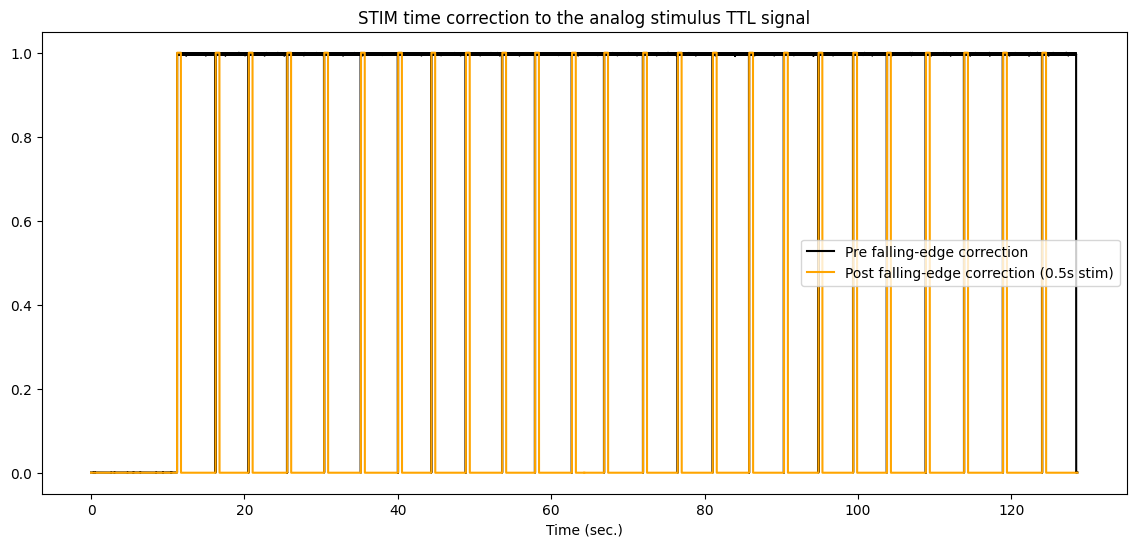

In [9]:
# Optional correction of the analog experimental LED pulse falling edge:
plt.figure(figsize=(14,6))
if STIM_TYPE in ["LED", "AUDIO"]:
    # find the index of every first 1 occuring after a 0 
    corrected_wf_experimental = np.zeros_like(wf_exp_stim_pulses)
    corrected_wf_experimental[1:] = (wf_exp_stim_pulses[1:] >= 0.5) & (wf_exp_stim_pulses[:-1] <= 0.5)
    corrected_wf_experimental[0] = wf_exp_stim_pulses[0]
    corrected_wf_experimental = np.where(np.array(corrected_wf_experimental) > 0.5, 1, 0) # convert the array into a binary array 
    # for each start index (pusle), determine and add the end index
    indices = np.where(corrected_wf_experimental == 1)[0]

    stim_time_tuples = []
    for i in indices:
        stim_on = np.ones(int(1000 * stim_time))
        corrected_wf_experimental[i:i+int((1000 * stim_time))] = stim_on
        stim_time_tuples.append((analog_x_values[i], analog_x_values[i+int((1000 * stim_time))]))

    # since our sampling rate is 1000 Hz, 0.5 seconds would be 500 indices away. 

    plt.plot(analog_x_values, wf_exp_stim_pulses, color="black", label="Pre falling-edge correction")
    plt.plot(analog_x_values, corrected_wf_experimental, color="orange", label=f"Post falling-edge correction ({stim_time}s stim)")
    plt.legend()
    plt.title("STIM time correction to the analog stimulus TTL signal")
    plt.xlabel("Time (sec.)")
    plt.show()

if STIM_TYPE == 'OLFAC':
    # find the index of every first 1 occuring after a 0 
    corrected_wf_experimental = np.zeros_like(wf_exp_stim_pulses)
    corrected_wf_experimental[1:] = (wf_exp_stim_pulses[1:] >= 0.5) & (wf_exp_stim_pulses[:-1] <= 0.5)
    corrected_wf_experimental[0] = wf_exp_stim_pulses[0]
    corrected_wf_experimental = np.where(np.array(corrected_wf_experimental) > 0.5, 1, 0) # convert the array into a binary array 
    # for each start index (pusle), determine and add the end index
    indices = np.where(corrected_wf_experimental == 1)[0]

    print(f"Mix duration: {stim_configs['experiment_config']['MIX_DURATION']}")
    print(f"Odor duration: {stim_configs['experiment_config']['ODOR_DURATION']}")

    corrected_wf_experimental = np.zeros_like(wf_exp_stim_pulses)
    for i in indices:
        stim_start = i + int(1000 * stim_configs['experiment_config']['MIX_DURATION'])
        stim_on = np.ones(int(1000 * (stim_configs['experiment_config']['ODOR_DURATION'])))
        corrected_wf_experimental[stim_start:stim_start+len(stim_on)] = stim_on
    # since our sampling rate is 1000 Hz, 0.5 seconds would be 500 indices away. 

    plt.plot(analog_x_values, wf_exp_stim_pulses, color="black", label="Pre falling-edge correction")
    plt.plot(analog_x_values, corrected_wf_experimental, color="orange", label=f"Post falling-edge correction ({stim_time}s stim)")
    plt.legend()
    plt.title("STIM time correction to the analog stimulus TTL signal")
    plt.xlabel("Time (sec.)")
    plt.show()

We can also look at the time differences between the blue and violet LED TTL pulses. Compare this graph to that of the frame distances. They should be similar.

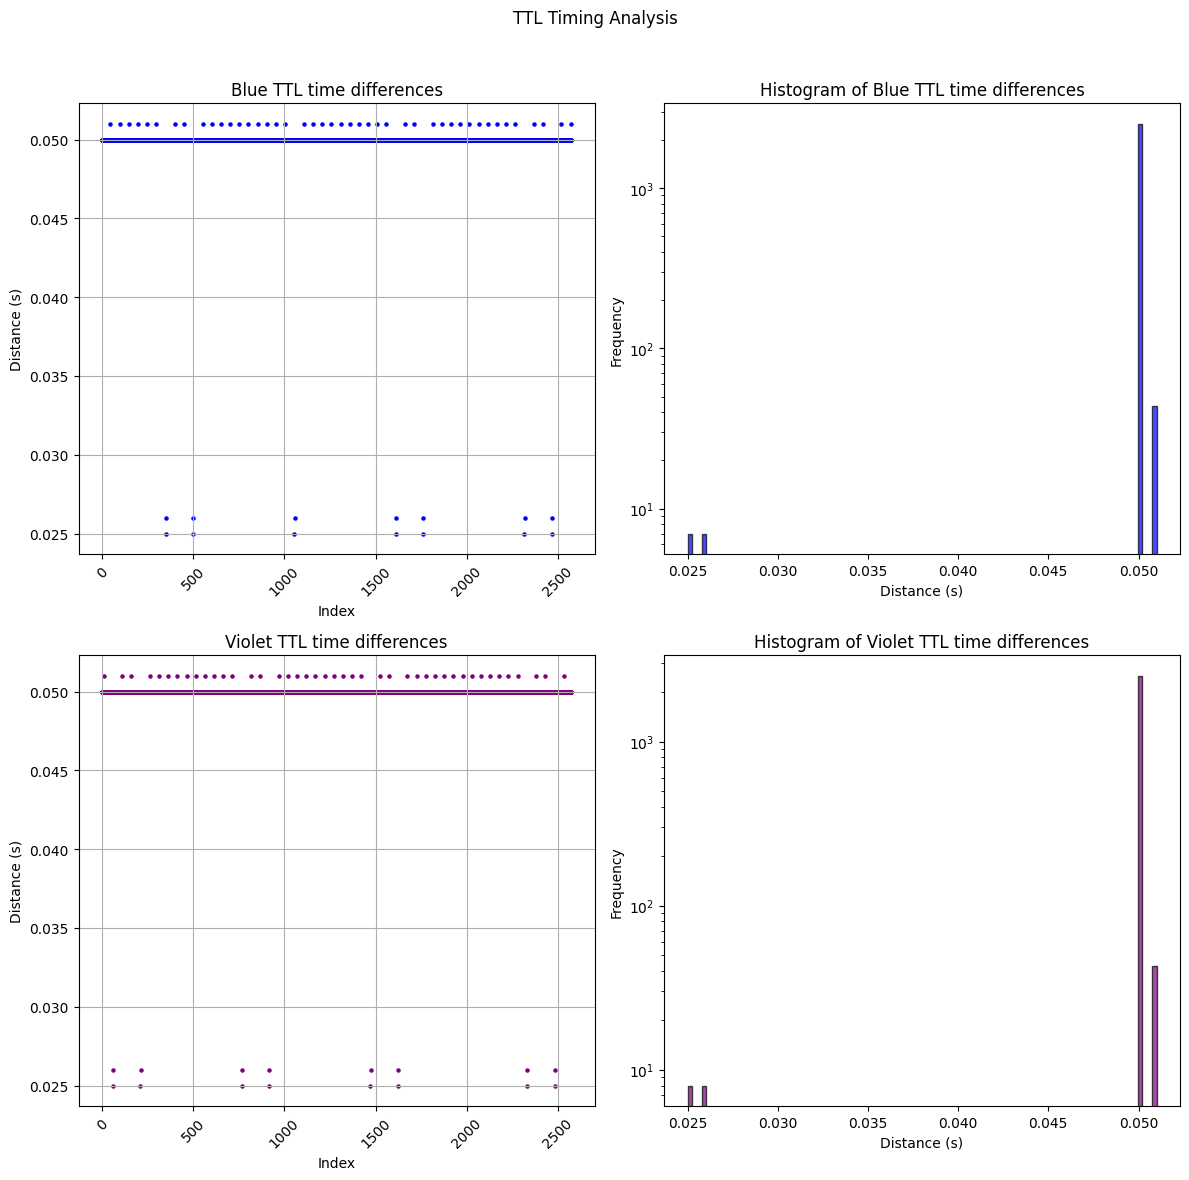

In [10]:
# Calculate distances in seconds between consecutive LED pulses
# First find all rising edges: 
blue_TTL_risings = find_rising_edges(wf_m_blueLED)
blue_TTL_risings = analog_x_values[blue_TTL_risings]
violet_TTL_risings = find_rising_edges(wf_m_violetLED)
violet_TTL_risings = analog_x_values[violet_TTL_risings]

blue_distances = (blue_TTL_risings[1:] - blue_TTL_risings[:-1])
violet_distances = (violet_TTL_risings[1:] - violet_TTL_risings[:-1])

# Create the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("TTL Timing Analysis")

# 1. Scatter plot: blue distances
axes[0, 0].scatter(np.arange(len(blue_distances)), blue_distances, s=5, color='blue')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Distance (s)')
axes[0, 0].set_title("Blue TTL time differences")
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0,0].grid()

# 2. Scatter plot: violet distances
axes[1, 0].scatter(np.arange(len(violet_distances)), violet_distances, s=5, color='purple')
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Distance (s)')
axes[1, 0].set_title("Violet TTL time differences")
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1,0].grid()

# 3. Histogram: blue distances
axes[0, 1].hist(blue_distances, color='blue', bins=100, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Distance (s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Histogram of Blue TTL time differences')

# 4. Histogram: violet distances
axes[1, 1].hist(violet_distances, bins=100, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Distance (s)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Histogram of Violet TTL time differences')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()

If you have issues in the below cell, change the threshold variable such that it's value is high enough to capture only frames that are illuminated by the LED / that are in the "stim" pulses.

In [11]:
if IS_ALIGNMENT_TEST:    
    # for each pulse, identify the start and end frame index for both channels 
    threshold = 0.8 # change as necessary based on data / baseline values 

    # Find where the data crosses above or below the threshold
    transitions_b = np.diff(normalized_blue_mean > threshold)
    transitions_v = np.diff(normalized_violet_mean > threshold)

    # Start indices: where transitions go from False to True
    starts_b = np.where(~transitions_b[:-1] & transitions_b[1:])[0] + 1
    stops_b = np.where(transitions_b[:-1] & ~transitions_b[1:])[0] + 1
    starts_v = np.where(~transitions_v[:-1] & transitions_v[1:])[0] + 1
    stops_v = np.where(transitions_v[:-1] & ~transitions_v[1:])[0] + 1

    # Combine start and stop indices into tuples
    b_pulse_index_ss = list(zip(starts_b, stops_b))
    print(b_pulse_index_ss)
    v_pulse_index_ss = list(zip(starts_v, stops_v))
    print(v_pulse_index_ss)

    plt.figure(figsize=(15, 5))
    plt.title("Frames during which stim is on")
    
    plt.scatter(blue_fTimes, normalized_blue_mean, s=5, color = 'royalblue', label=f"Normalized blue frame signal (n={len(normalized_blue_mean)})")
    plt.plot(blue_fTimes, normalized_blue_mean, linewidth=0.5, color = 'royalblue')

    plt.scatter(violet_fTimes, normalized_violet_mean, s=5, color = 'purple', label=f"Normalized violet frame signal (n={len(normalized_violet_mean)})")
    plt.plot(violet_fTimes, normalized_violet_mean, linewidth=0.5, color = 'purple')

    counter = 1
    print(f"Duration of time frames have mean value above threshold={threshold} for:")
    for i in range(0, len(b_pulse_index_ss), 2):  # Iterate over start-stop pairs
        plt.axvspan(blue_fTimes[b_pulse_index_ss[i][1]], blue_fTimes[b_pulse_index_ss[i+1][0]], color='blue', alpha=0.3, label="Blue Frames: Stim on" if i == 0 else None)
        plt.axvspan(violet_fTimes[v_pulse_index_ss[i][1]], violet_fTimes[v_pulse_index_ss[i+1][0]], color='purple', alpha=0.3, label="Violet Frames: Stim on" if i == 0 else None)
        print(f"stim pres {counter}: {max(blue_fTimes[b_pulse_index_ss[i+1][0]], (violet_fTimes[v_pulse_index_ss[i+1][0]])) - min(blue_fTimes[b_pulse_index_ss[i][1]], (violet_fTimes[v_pulse_index_ss[i][1]]))}s")
        counter += 1
        '''if i != 0:
            inter_stim_duration = max(frame_x_signal[b_pulse_index_ss[i+1][0]], (frame_x_signal[v_pulse_index_ss[i+1][0]] + 1/40)) - prev_end
            print(f"Inter stim duration between stim {counter-2} and {counter-1}: {inter_stim_duration}s")
            inter_pulse_durations.append(inter_stim_duration)
        prev_end = max(frame_x_signal[b_pulse_index_ss[i+1][0]], (frame_x_signal[v_pulse_index_ss[i+1][0]] + 1/40))

    print(f"\nJiiter array: { stim_configs['experiment_config']["JITTER"]}")'''
    
    plt.show()
        
    # Let's do the same analysis with the analog computer corrected pulses 
        # corrected_wf_experimental
        # stim_time_tuples

    inter_pulse_durations = []
    for i in range(len(stim_time_tuples)-1):  # Iterate over start-stop pairs
        print(f"Inter stim btwn stim {i+1} and {i+2}: {stim_time_tuples[i+1][0] - stim_time_tuples[i][1]}s")
        inter_pulse_durations.append(stim_time_tuples[i+1][0] - stim_time_tuples[i][1])

    print(f"Duration when jitter-adjusted: {inter_pulse_durations + -1*stim_configs['experiment_config']["JITTER"][:-1]}")


## Stimulus file data exploration

We will first explore the stimulus file (matlab) data that is unique from the analog data. 

The following data are worth exploring in depth:
- stim configs
- stim frame info (called stim_frame_times in our recording object)
- stim params


#### Stim_Configs: 

For both the 'OLFAC' and 'LED' stim types, the stim_configs dictionary has the followings key values: ['serialized', 'machine_config', 'experiment_config', 'hash']. 

- The *serialized* and *hash* data have not been explored in either stim type but are not necessary for our analysis. 
- The *machine_config* keys are the same between both LED and OLFAC stim types

The *experimental_config* are different bettwen the stimulus types (detailed in the table below)

| |stim_configs['experimental_configs']| | |
|:------------:|:------------:|:------------:|:-----------------:|
| **Common to ALL stim types** |**Unique to 'LED'**| **Unique to 'OLFAC'**|**Unique to 'AUDIO'**|
| 'BASELINE_TIME', 'ENABLE_JITTER', 'JITTER', 'JITTER_RANGE', 'REPEATS' | 'FLASH_AMPLITUDE', 'FLASH_TIME', 'FSAMPLE', 'LED_CHANNEL', 'POST_FLASH_BASELINE', 'WAVEFORM', 'WAVEFORMS' | 'EMULATE_ODOR', 'LIST_OF_ODORS', 'MIX_DURATION', 'ODOR_DURATION', 'ODOR_NAME', 'POST_DELAY', 'PRE_DELAY'| 'TONE_PATTERN', 'BALANCE', 'POST_TONE_BASELINE', 'TONE_AMPLITUDE', 'TONE_FREQUENCY', 'TONE_TIME' |


#### Stim_Frame_Times: 

For all stim types, stimulus_frame_info is an array representing the timestamps at which the stimulus occurs.  

#### Stim_Params

The *stim_params* dictionary keys are the same between the 'OLFAC' and 'LED' stim types. 
|stim_params dictionary keys (common to ALL stim types)|
|:---------------------------------------------:|
|'Animal', 'Beep_Duration', 'Beep_Frequency', 'Bullseye_On', 'Bullseye_Shape', 'Bullseye_Size', 'Enable_Psychotoolbox', 'Enable_Widefield', 'Grey_Level', 'Hold_Stable_at_Reward', 'Main_Tab', 'Max_trials', 'Name', 'Noise_Duration', 'Olfacto_Stimulus_Duration', 'Record_Eyecamera', 'Repeat_until_correct', 'Restrict_Stimulus_Side', 'Reward_Delay', 'Reward_Stimulus_Ratio', 'Reward_Zone_Tolerance', 'Selected_experiment_class', 'Snap_Time', 'Spatial_Frequency', 'Step_Size', 'Stimulus_Background_Color', 'Stimulus_Center_X', 'Stimulus_Center_Y', 'Stimulus_Size', 'Trial_Time', 'Trials', 'Valve_Open_Time', 'Wheel_Stable_Time', 'animal', 'duration', 'eyecamfilename', 'id', 'machine_config', 'name', 'outfilename', 'outfolder', 'partial_data', 'region_name', 'status', 'stimclass', 'stimfile', 'stimulus_source_code', 'user'|
| for data_type == "NEW", there is an added param: 'Intertrial_Wait' |


In [12]:
# Print config variables that could be used to alignments or sanity checks: 
print("------------------------------------------------- From Machine_Config --------")
print(f"CAMERA_PRETRIGGER_TIME: { stim_configs['machine_config']['CAMERA_PRETRIGGER_TIME']}")
print(f"CAMERA_START_TIME: { stim_configs['machine_config']['CAMERA_START_TIME']}")
print(f"STIM_SYNC_CHANNEL_INDEX: { stim_configs['machine_config']['STIM_SYNC_CHANNEL_INDEX']}")
print(f"SYNC_RECORDER_SAMPLE_RATE: { stim_configs['machine_config']['SYNC_RECORDER_SAMPLE_RATE']}")
print(f"DATA_READY_TIMEOUT: { stim_configs['machine_config']["DATA_READY_TIMEOUT"]}")
print(f"FRAME_TIMING_PULSE_WIDTH: { stim_configs['machine_config']["FRAME_TIMING_PULSE_WIDTH"]}")
print(f"FRAME_WAIT_FACTOR: { stim_configs['machine_config']["FRAME_WAIT_FACTOR"]}")
print(f"STIMULATION_AND_IMAGING_START_TIMEOUT: { stim_configs['machine_config']["STIMULATION_AND_IMAGING_START_TIMEOUT"]}")
print(f"STIM_RECORDS_ANALOG_SIGNALS: { stim_configs['machine_config']["STIM_RECORDS_ANALOG_SIGNALS"]}")

print("------------------------------------------------- From stim sync scaling --------")
print(f"offset: { stim_sync_scaling['offset']}")
print(f"range: { stim_sync_scaling['range']}")
print(f"scale: { stim_sync_scaling['scale']}")

print("------------------------------------------------- From Experiment_Config --------")
print(f"BASELINE_TIME: { stim_configs['experiment_config']['BASELINE_TIME']}")
print(f"REPEATS: { stim_configs['experiment_config']['REPEATS']}")
print(f"JITTER_ARRAY shape: { stim_configs['experiment_config']["JITTER"].shape}")
print(f"JITTER_RANGE: { stim_configs['experiment_config']["JITTER_RANGE"]}")

if  STIM_TYPE == 'LED':
    print(f"FLASH_TIME: { stim_configs['experiment_config']['FLASH_TIME']}")
    print(f"POST_FLASH_BASELINE: { stim_configs['experiment_config']['POST_FLASH_BASELINE']}")
    print(f"FSAMPLE: { stim_configs['experiment_config']['FSAMPLE']}")
    if DATA_FORMAT == 'NEW':
        print("------------------------------------------------- From Params --------")
        print(f"Intertrial_Wait: { stim_params.get("Intertrial_Wait", "Key does not exist")}") # in some "NEW" experiments, this key does not exist...

if  STIM_TYPE == 'OLFAC':
    print(f"EMULATE_ODOR: { stim_configs['experiment_config']['EMULATE_ODOR']}")
    print(f"LIST_OF_ODORS: { stim_configs['experiment_config']['LIST_OF_ODORS']}")
    print(f"MIX_DURATION: { stim_configs['experiment_config']['MIX_DURATION']} s")
    print(f"ODOR_DURATION: { stim_configs['experiment_config']['ODOR_DURATION']} s")
    if DATA_FORMAT == "OLD":
        print(f"ODOR_NAME: { stim_configs['experiment_config']['ODOR_NAME']}")
        print(f"PRE_DELAY: { stim_configs['experiment_config']['PRE_DELAY']}")
        print(f"POST_DELAY: { stim_configs['experiment_config']['POST_DELAY']}")
    elif DATA_FORMAT == "NEW":
        print(f"DELIVERED_ODORS: { stim_configs['experiment_config']['DELIVERED_ODORS']}")
        print(f"INTERTRIAL_INTERVAL: { stim_configs['experiment_config']['INTERTRIAL_INTERVAL']} ms")

    print("------------------------------------------------- From Params --------")
    print(f"duration: { stim_params["duration"]}")
    print(f"Olfacto_stimulus_duration: { stim_params["Olfacto_Stimulus_Duration"]} ms")
    print(f"Trial_Time: { stim_params["Trial_Time"]}")
    print(f"Trials: { stim_params["Trials"]}")
    print(f"Intertrial_Wait: { stim_params["Intertrial_Wait"]}")

if  STIM_TYPE == 'AUDIO':
    print(f"TONE_PATTERN: { stim_configs['experiment_config']['TONE_PATTERN']}")
    print(f"BALANCE: { stim_configs['experiment_config']['BALANCE']}")
    print(f"POST_TONE_BASELINE: { stim_configs['experiment_config']['POST_TONE_BASELINE']}")
    print(f"TONE_AMPLITUDE: { stim_configs['experiment_config']['TONE_AMPLITUDE']}")
    print(f"TONE_FREQUENCY: { stim_configs['experiment_config']['TONE_FREQUENCY']}")
    print(f"TONE_TIME: { stim_configs['experiment_config']['TONE_TIME']}")
    print("------------------------------------------------- From Params --------")
    print(f"Intertrial_Wait: { stim_params["Intertrial_Wait"]}")


------------------------------------------------- From Machine_Config --------
CAMERA_PRETRIGGER_TIME: 0
CAMERA_START_TIME: 1
STIM_SYNC_CHANNEL_INDEX: -1
SYNC_RECORDER_SAMPLE_RATE: 10000
DATA_READY_TIMEOUT: 10
FRAME_TIMING_PULSE_WIDTH: 0.001
FRAME_WAIT_FACTOR: 0.9
STIMULATION_AND_IMAGING_START_TIMEOUT: 10
STIM_RECORDS_ANALOG_SIGNALS: True
------------------------------------------------- From stim sync scaling --------
offset: -0.0017783790809060562
range: 4.92999068623376
scale: 13293.128561681953
------------------------------------------------- From Experiment_Config --------
BASELINE_TIME: 5
REPEATS: 25
JITTER_ARRAY shape: (25,)
JITTER_RANGE: [-0.5, 0.5]
FLASH_TIME: 0.5
POST_FLASH_BASELINE: 4
FSAMPLE: 1000


### Stimulus computer data similar to the analog data 

We will next observe that the stimulus computer has similar data to that of the analog file:
- stim computer experimental start time 
    - (stored in its own variable in the matlab file)
- stim experimental LED TTL pulses 
    - (stored in a variable called 'sync')
    - the type of data is the same between the 'OLFAC' and 'LED' stimuli but the order in which they appear in the 'sync' array is ***different***

We will further explore these files to understand potential alignment strategies

Based on the stimulus computer: experimental start time = 2025-01-08 17:00:45.932799


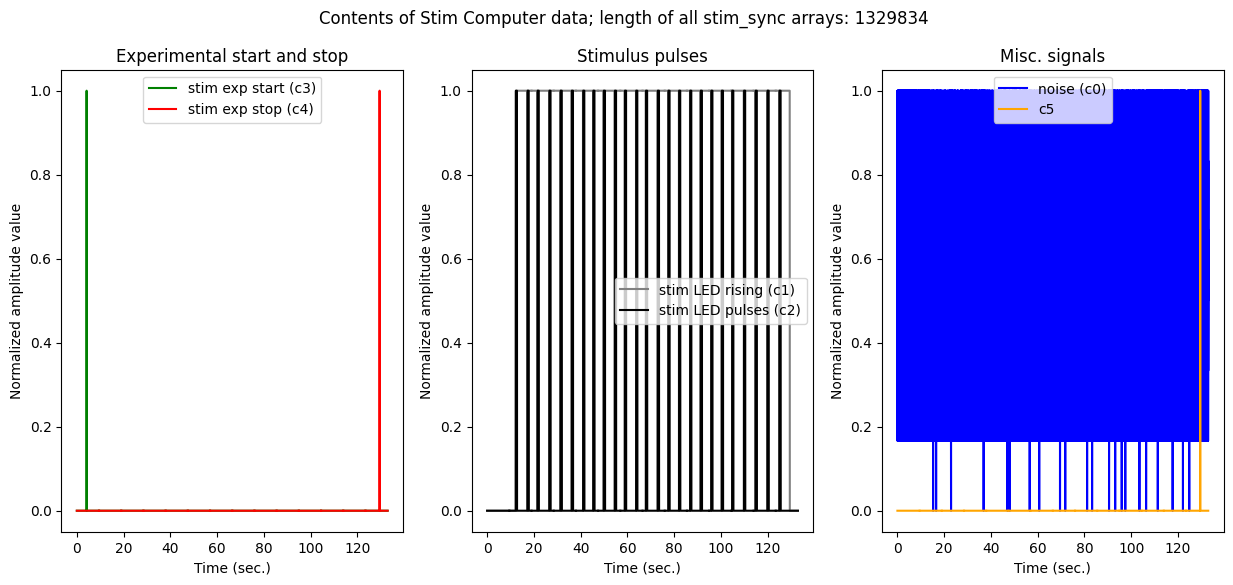

The rising edge index of the 'stim exp start pulse' is 41181 == 4.1181s

The rising edge index of the 'stim exp stop c4 pulse' is 1294712 == 129.4712s (3.5121000000000038s from the end)
The rising edge index of the 'stim exp stop c5 pulse' is [0 0 0 ... 0 0 0] == 129.4712s (3.5121000000000038s from the end)

'stim channel 4' and 'stim channel 5' are identical: True
'corrected_stim_channel_one' and 'binary_stim_exp_pulses' are identical: False


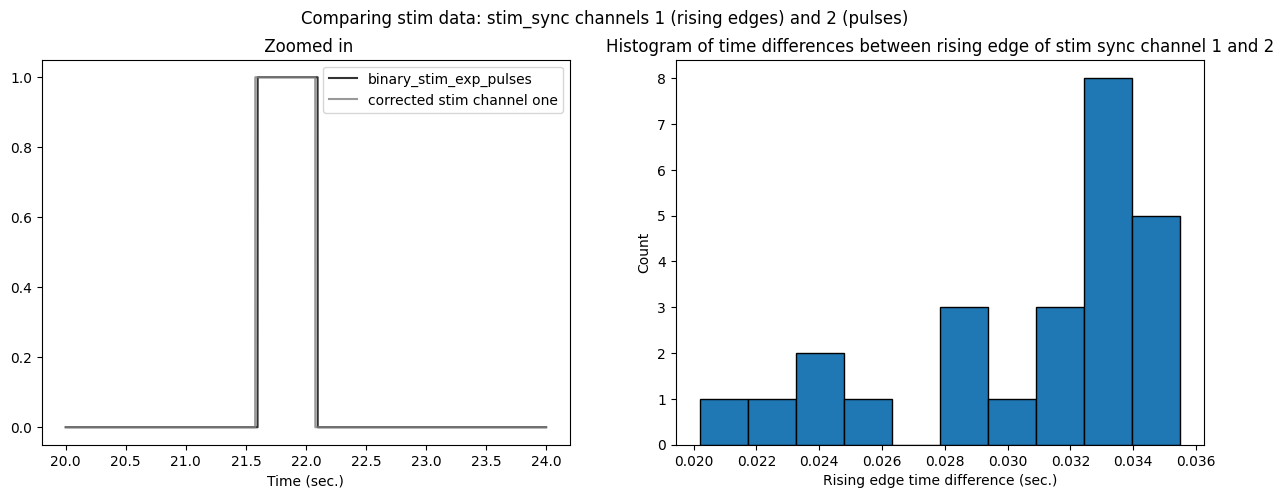

Mean distance between c1 and c2 rising edges: 0.030555999999998775


In [13]:
# Visualizing the contents of the stim files. 

# Stim computer Experimental start time
if DATA_FORMAT == "OLD": # there's no stim time stamp...
    print(f"Based on the stimulus computer: experimental start time = {datetime.datetime.fromtimestamp(stim_experiment_start_timestamp)}")

stim_c0 = normalize_arr(stim_sync[:,0])                           # c0 = noise (for ALL STIM TYPES) 
stim_c1 = normalize_arr(stim_sync[:,1])                           # c1 = stim analog-like pulse (for ALL STIM TYPES) 
stim_c1 = np.where(np.array(stim_c1) > 0.5, 1, 0) # make binary array
stim_c2 = normalize_arr(stim_sync[:,2])                           # c2  **stim_type-dependent**
stim_c3 = normalize_arr(stim_sync[:,3])                           # c3 = stim experiment start time (for ALL STIM TYPES) (aquisition start for wfield)
stim_c3 = np.where(np.array(stim_c3) > 0.5, 1, 0) # make binary array
stim_c4 = normalize_arr(stim_sync[:,4])                           # c4 = stim experiment stop time (for ALL STIM TYPES)
stim_c4 = np.where(np.array(stim_c4) > 0.5, 1, 0) # make binary array
stim_c5 = normalize_arr(stim_sync[:,5])                           # c5 = **stim_type-dependent**
# The stim_sync array in data created on or after February 14th 2025 now contains a 7th column. 
if DATA_FORMAT == "NEW": stim_c6 = normalize_arr(stim_sync[:,6])  # c6 = **stim_type-dependent**

# make an array of time domain x-values
stim_x_values = np.arange(stim_sync.shape[0]) / 10000

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
plt.suptitle(f"Contents of Stim Computer data; length of all stim_sync arrays: {len(stim_x_values)}")

axes[0].plot(stim_x_values, stim_c3, color="green",label=("stim exp start (c3)"))
axes[0].plot(stim_x_values, stim_c4, color="red", label=("stim exp stop (c4)"))
axes[0].set_title("Experimental start and stop")
axes[0].legend()
axes[0].set_xlabel("Time (sec.)")
axes[0].set_ylabel("Normalized amplitude value")

axes[2].plot(stim_x_values, stim_c0, color="blue", label=("noise (c0)"))

if STIM_TYPE == "LED": 
    # LED channel 2 = stimulus presentation pulse with the correct duration
    # LED channel 5 = stop pulse for data_format=="OLD", = noise for data_format=="NEW"
    # LED channel 6 (if data_type=="NEW") is noise
    stim_c5 = np.where(np.array(stim_c5) > 0.75, 1, 0) # convert the array into a binary array for readability
    stim_c2 = np.where(np.array(stim_c2) > 0.75, 1, 0)

    axes[2].plot(stim_x_values, stim_c5, color="orange", label=("c5"))             # NOTE: has gotten crazy since feb 14th data
    if DATA_FORMAT == "NEW":
        axes[2].plot(stim_x_values, stim_c6, color="gray", label=("noise (c6)"))
    axes[1].plot(stim_x_values, stim_c1, color="gray", label =("stim LED rising (c1)"))
    axes[1].plot(stim_x_values, stim_c2, color="black", label=("stim LED pulses (c2)"))

if STIM_TYPE == 'OLFAC':
    # OLFAC channel 2 = noise
    # OLFAC channel 5 = may be the photodiode read out (?) unsure as of 02-20-2025
    # OLFAC channel 6 = photodiode pulses 
    if DATA_FORMAT == "NEW":
        stim_c6 = np.where(np.array(stim_c6) > 0.75, 1, 0) 
        axes[1].plot(stim_x_values, stim_c6, color="red", label=("photodiode (c6)"))
        stim_c5 = np.where(np.array(stim_c5) > 0.75, 1, 0) 

    axes[1].plot(stim_x_values, stim_c5, color="orange", label=("c5 pulses"))             # NOTE: may contain the LED photodiode since Feb 14th 2025
    axes[1].plot(stim_x_values, stim_c1, color="black", label=("stim OLFAC rising (c1)"))
    axes[2].plot(stim_x_values, stim_c2, color="gray", label=("noise (c2)"))
    
if STIM_TYPE == "AUDIO":
    # AUDIO channel 5 = noise but has some signal that resembles the pulses 
    # AUDIO channel 0, 2, 6 = noise
    axes[1].plot(stim_x_values, stim_c1, color="black", label=("stim AUDIO rising (c1)"))
    axes[1].plot(stim_x_values, stim_c5, color="gray", label=("noise (c5)"))


axes[1].set_title("Stimulus pulses")
axes[1].legend()
axes[1].set_xlabel("Time (sec.)")
axes[1].set_ylabel("Normalized amplitude value")

axes[2].set_xlabel("Time (sec.)")
axes[2].set_ylabel("Normalized amplitude value")
axes[2].set_title("Misc. signals")
axes[2].legend()    

plt.show()

# we can also determine the index of the rising edge of the 'stim_exp_start' and stim_exp_stop pulses 
stim_start_idx = np.where(stim_c3 > 0.5)[0][0]
stim_stop_idx = np.where(stim_c4 > 0.5)[0][0]

print(f"The rising edge index of the 'stim exp start pulse' is {stim_start_idx} == {stim_x_values[stim_start_idx]}s")
print(f"\nThe rising edge index of the 'stim exp stop c4 pulse' is {stim_stop_idx} == {stim_x_values[stim_stop_idx]}s ({stim_x_values[-1] - stim_x_values[stim_stop_idx]}s from the end)")

# ------------------ EXTRA PLOTS FOR SPECIFIC STIM_TYPES -------------------
if STIM_TYPE == "OLFAC":
    plt.figure(figsize=(15, 6))
    plt.title(f"ZOOMED: Stim computer c5 photodiode and c1 stim pulses")
    plt.plot(stim_x_values, stim_c5, color="orange", label=("pulse c5)"))      
    plt.plot(stim_x_values, stim_c1, color="black", label=("pulse c1"), alpha=0.9)
    if DATA_FORMAT == "NEW":
        stim_photodiode = normalize_arr(stim_sync[:,6])
        plt.plot(stim_x_values, stim_photodiode, color="red", label=("photodiode (c6)"), alpha=0.8)
    plt.legend()
    plt.xlim((55, 75))
    plt.show()

    # determine the distances between the two arrays
    if DATA_FORMAT == "NEW":
        stim_rising = find_rising_edges(stim_c1)
        photodiode_rising = find_rising_edges(stim_c6)

        # compute lags (time difference) for rising edges (since both pulses are exactly stim_time in length, we only need to look at one of rising or falling edge differences)
        rising_lags = np.abs(stim_x_values[photodiode_rising] - stim_x_values[stim_rising]) 

        plt.hist(rising_lags, edgecolor="black")
        plt.xlabel("Rising edge time difference (sec.)")
        plt.ylabel("Count")
        plt.title("Histogram of time differences between rising edge of stim sync channel 1 and 6")

        plt.show()

        comp_dist = np.mean(rising_lags)
        print(f"Mean distance between c6 (photod) and c1 (stim) rising edges: {comp_dist}")

if STIM_TYPE == "LED":
    stim_stop_idx_5 = np.where(stim_c5 > 0.5)[0][0]
    print(f"The rising edge index of the 'stim exp stop c5 pulse' is {stim_c5} == {stim_x_values[stim_stop_idx_5]}s ({stim_x_values[-1] - stim_x_values[stim_stop_idx_5]}s from the end)\n")

    # are channel 5 and the stim exp stop pulse identical? Yes
    print(f"'stim channel 4' and 'stim channel 5' are identical: {stim_stop_idx_5 == stim_stop_idx}")

    # are the rising edge of stim_exp_pulses and channel 1 identical? No
    binary_stim_exp_pulses = np.where(np.array(stim_c2) > 0.8, 1, 0)
    corrected_stim_channel_one = np.zeros_like(stim_c1)
    corrected_stim_channel_one[1:] = (stim_c1[1:] == 1) & (stim_c1[:-1] == 0)
    corrected_stim_channel_one[0] = stim_c1[0]
    indices = np.where(corrected_stim_channel_one == 1)[0]
    stim_time_tuples = []
    for i in indices:    # since our sampling rate is 10000 Hz, 0.5 seconds would be 5000 indices away. 
        stim_on = np.ones(int(10000 * stim_time))
        corrected_stim_channel_one[i:i+int(10000 * stim_time)] = stim_on
        stim_time_tuples.append((stim_x_values[i], stim_x_values[i+int(10000 * stim_time)]))

    print(f"'corrected_stim_channel_one' and 'binary_stim_exp_pulses' are identical: {np.array_equal(binary_stim_exp_pulses, corrected_stim_channel_one)}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plt.suptitle(f"Comparing stim data: stim_sync channels 1 (rising edges) and 2 (pulses)")

    axes[0].plot(stim_x_values[200000:240000], binary_stim_exp_pulses[200000:240000], color="black", alpha=0.8, label="binary_stim_exp_pulses")
    axes[0].plot(stim_x_values[200000:240000], corrected_stim_channel_one[200000:240000], color="gray", alpha=0.8, label="corrected stim channel one")
    axes[0].set_title("\n Zoomed in")
    axes[0].set_xlabel("Time (sec.)")
    axes[0].legend()

    # determine the distances between the two arrays
    # rising edges (0 -> 1) and falling edges (1 -> 0)
    def find_edges(signal):
        rising_edges = np.where(np.diff(signal) == 1)[0] + 1  # +1 to get the index of the 1
        falling_edges = np.where(np.diff(signal) == -1)[0] + 1  # +1 to get the index of the 0
        return rising_edges, falling_edges

    rising_exp_pulse, falling_exp_pulse = find_edges(binary_stim_exp_pulses)
    rising_chan_one, falling_chan_one = find_edges(corrected_stim_channel_one)

    # compute lags (time difference) for rising edges (since both pulses are exactly stim_time in length, we only need to look at one of rising or falling edge differences)
    rising_lags = np.abs(stim_x_values[rising_exp_pulse] - stim_x_values[rising_chan_one]) 

    axes[1].hist(rising_lags, edgecolor="black")
    axes[1].set_xlabel("Rising edge time difference (sec.)")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Histogram of time differences between rising edge of stim sync channel 1 and 2")

    plt.show()

    comp_dist = np.mean(rising_lags)
    print(f"Mean distance between c1 and c2 rising edges: {comp_dist}")

**OLFAC Photodiode**:  
- The sensor detects if the “no odor” valve is open on the olfactometer
- When an odor opens, the "no odor" valve closes. This results in the photodiode signal being off during odor delivery 

In [14]:
if IS_ALIGNMENT_TEST:
    inter_pulse_durations = []
    for i in range(len(stim_time_tuples)-1):  # Iterate over start-stop pairs
        print(f"Inter stim btwn stim {i+1} and {i+2}: {stim_time_tuples[i+1][0] - stim_time_tuples[i][1]}s")
        inter_pulse_durations.append(stim_time_tuples[i+1][0] - stim_time_tuples[i][1])

    print(f"Duration when jitter-adjusted: {inter_pulse_durations - stim_configs['experiment_config']["JITTER"][:-1]}")
    print(f"Average inter-pulse duration: {np.mean(np.array(inter_pulse_durations - stim_configs['experiment_config']["JITTER"][:-1]))}")
    print(f"This should correspond to the post_flash_baseline time: {stim_configs['experiment_config']['POST_FLASH_BASELINE']}")

Since we have access to the same stim pulse (stim_sync c1) data from both the stim and analog computer files, we can determine the shift in seconds needed to align them. 
- Is this shift constant between the two computers? ie. is this signal the same + an offset between the two computers? (yes)

stim rising edge times: [  4.1181  12.2362  17.2607  21.5772  26.6024  31.4199  36.2092  41.0512
  45.388   49.8931  54.6321  58.9174  63.7234  67.9274  72.9982  77.5203
  82.0907  86.8295  91.3679  95.8685 100.3931 104.7974 109.8708 114.8579
 119.9288 125.0352]

wf rising edge times: [  3.097  11.215  16.239  20.556  25.581  30.398  35.187  40.029  44.366
  48.87   53.609  57.894  62.7    66.904  71.975  76.497  81.067  85.805
  90.344  94.844  99.368 103.773 108.846 113.833 118.903 124.01 ]

mean shift (stim-wf) = 1.023253846153847


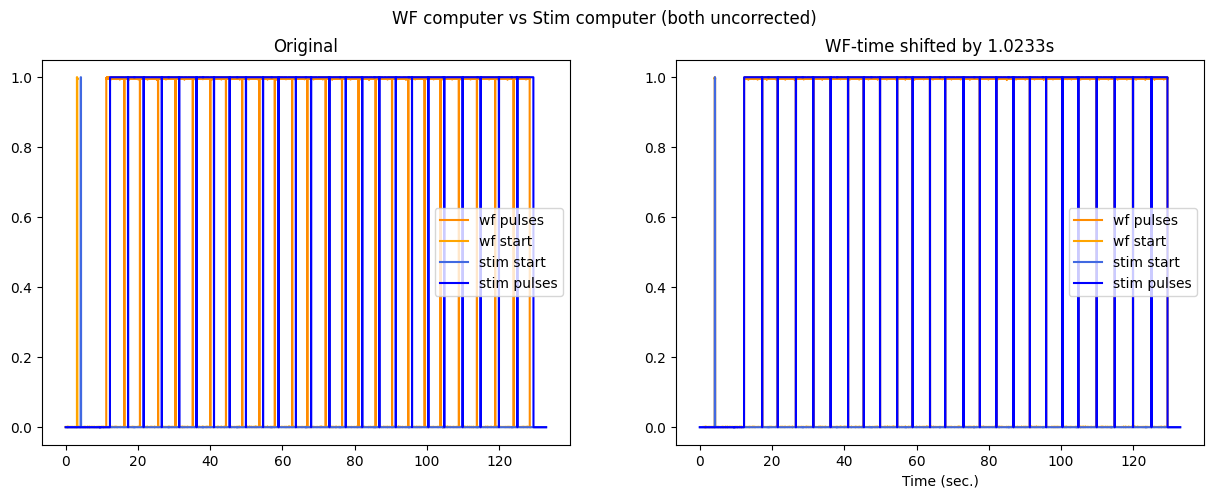

In [15]:
# determine the amount of shift needed for the two signals to be aligned
stim_rIndices = find_rising_edges(stim_c1)
stim_rTime = stim_x_values[stim_rIndices]
stim_rStart = stim_x_values[find_rising_edges(stim_c3)]
stim_all_times = np.concatenate((stim_rStart, stim_rTime))
print(f"stim rising edge times: {stim_all_times}")

wf_rIndices = find_rising_edges(wf_exp_stim_pulses)
wf_rTime = analog_x_values[wf_rIndices]
wf_rStart = analog_x_values[find_rising_edges(wf_received_exp_start)]
wf_all_times = np.concatenate((wf_rStart, wf_rTime))
print(f"\nwf rising edge times: {wf_all_times}")

mean_shift = np.mean(stim_all_times - wf_all_times)
print(f"\nmean shift (stim-wf) = {mean_shift}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("WF computer vs Stim computer (both uncorrected)")

axes[0].plot(analog_x_values, wf_exp_stim_pulses, label="wf pulses", color='darkorange')
axes[0].plot(analog_x_values, wf_received_exp_start, label="wf start", color='orange')
axes[0].plot(stim_x_values, stim_c3, label="stim start", color='royalblue')
axes[0].plot(stim_x_values, stim_c1, label="stim pulses", color='blue')
axes[0].legend()
axes[0].set_title("Original")
plt.xlabel("Time (sec.)")

new_analog_x = analog_x_values + mean_shift
axes[1].plot(new_analog_x, wf_exp_stim_pulses, label="wf pulses", color='darkorange')
axes[1].plot(new_analog_x, wf_received_exp_start, label="wf start", color='orange')
axes[1].plot(stim_x_values, stim_c3, label="stim start", color='royalblue')
axes[1].plot(stim_x_values, stim_c1, label="stim pulses", color='blue')
axes[1].legend()
axes[1].set_title(f"WF-time shifted by {round(mean_shift, 4)}s")
plt.xlabel("Time (sec.)")

plt.show()

***Note***: While the analog experimental start is in matlab time, the stimulus computer uses python's datetime...

We'll next explore the Stim pulse times variable which we find in the file from the stim computer (.mat)

Stim frame times data shape: 50
first stim frame time: 2025-01-08 17:00:57.168901
last stim frame time: 2025-01-08 17:02:54.390081
Time between start and first flash (stim comp perspective): 0:00:11.236102
Stim duration: 0.5s
ORIGINAL Mean stim duration based on 'stim_pulse_times' variable: 0:00:04.655014
ADJUSTED Mean stim duration: 0:00:00.500000


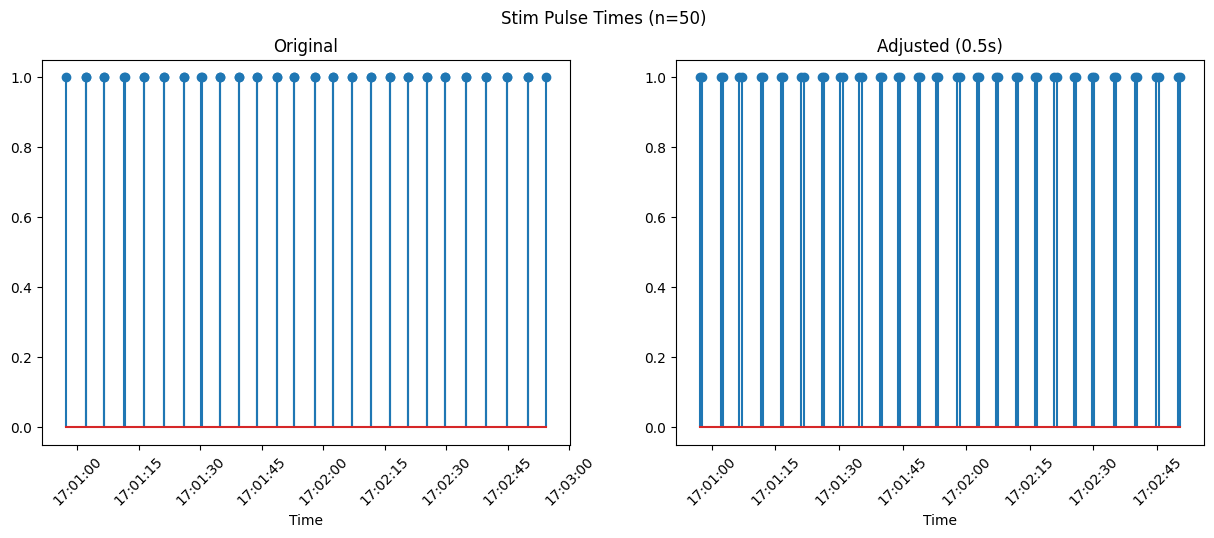

In [16]:
# explore the stim times variable

print(f"Stim frame times data shape: {len(stim_pulse_times)}")

print(f"first stim frame time: {stim_pulse_times[0]}")
print(f"last stim frame time: {stim_pulse_times[-1]}")

if DATA_FORMAT == "OLD":
    print(f"Time between start and first flash (stim comp perspective): {stim_pulse_times[0] - datetime.datetime.fromtimestamp(stim_experiment_start_timestamp)}")

# print the mean distance between the stim pulse times to see if they align with the "true" stim_time. 
print(f"Stim duration: {stim_time}s")
print(f"ORIGINAL Mean stim duration based on 'stim_pulse_times' variable: {np.mean((stim_pulse_times[1::2] - stim_pulse_times[0::2]))}")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle(f"Stim Pulse Times (n={len(stim_pulse_times)})")
axes[0].stem(stim_pulse_times, np.ones(len(stim_pulse_times)))
axes[0].set_xlabel("Time")
axes[0].set_title("Original")
axes[0].tick_params(axis='x', rotation=45)


# correction is needed to get the proper stim_time stim length 
adjusted_stim_pulse_times = np.copy(stim_pulse_times)

if STIM_TYPE in ["LED", "AUDIO"]:
    # Add STIM.TIME seconds to every second entry starting from the first
    for i in range(1, len(stim_pulse_times), 2):  # Start at index 1, step by 2
        adjusted_stim_pulse_times[i] = adjusted_stim_pulse_times[i - 1] + timedelta(seconds=stim_time)
    
    axes[1].set_title(f"Adjusted ({stim_time}s)")

elif STIM_TYPE == "OLFAC":
    # Add 'MIX_DURATION' to every other starting entry. This is now the odor delivery start. For the stop time, add 'ODOR_DURATION' to the delivery start time.
    axes[0].set_title(f"Original ({(stim_pulse_times[1] - stim_pulse_times[0]).total_seconds()}s)")

    for i in range(0, len(stim_pulse_times), 2):  # Start at index 0, step by 2
        odor_start = stim_pulse_times[i] + timedelta(seconds=stim_configs['experiment_config']['MIX_DURATION'])
        odor_stop = odor_start + timedelta(seconds=stim_configs['experiment_config']['ODOR_DURATION'])
        adjusted_stim_pulse_times[i:i+2] = [odor_start, odor_stop]
    
    axes[1].set_title(f"Adjusted ({stim_configs['experiment_config']['ODOR_DURATION']}s)")

print(f"ADJUSTED Mean stim duration: {np.mean((adjusted_stim_pulse_times[1::2] - adjusted_stim_pulse_times[0::2]))}")

axes[1].stem(adjusted_stim_pulse_times, np.ones(len(adjusted_stim_pulse_times)))
axes[1].set_xlabel("Time")
axes[1].tick_params(axis='x', rotation=45)

plt.show()

if IS_ALIGNMENT_TEST:
    inter_pulse_durations = []
    for i in range(0, len(adjusted_stim_pulse_times)-3, 2):  # Iterate over start-stop pairs
        inter_pulse_durations.append(adjusted_stim_pulse_times[i+2] - adjusted_stim_pulse_times[i+1])
    print(f"Inter stim times: {inter_pulse_durations}")

    corrected_durs = []
    for i, dur in enumerate(inter_pulse_durations):
        corrected_dur = inter_pulse_durations[i] - timedelta(seconds=stim_configs['experiment_config']["JITTER"][i])
        corrected_durs.append(corrected_dur)
    print(f"Jitter corrected inter stim times: {corrected_durs}")
    
    print(f"Average inter-pulse duration: {np.mean(np.array(corrected_durs))}")
    print(f"This should correspond to the post_flash_baseline time: {stim_configs['experiment_config']['POST_FLASH_BASELINE']}")


If the data_format == "NEW", we have a new variable called `tstim`. *(as of 2-19-2025)* This variable seems to be the time in seconds of the stimulus 

In [17]:
# If data format is new, we have access to a new data variable: tstim

if DATA_FORMAT == 'NEW':
    print(f"There are {len(tstim)} values in the tstim array")
    print(f"The stim 'times' could be the following: {tstim[0::2]}")
    
    fig, axes = plt.subplots(3, 1, figsize=(8, 13))

    axes[0].plot(tstim)
    axes[0].set_title("tstim array")
    axes[0].set_xlabel("index")
    axes[0].set_ylabel("seconds?")
    axes[0].grid()

    
    axes[1].plot(analog_x_values, wf_exp_stim_pulses, label="wf", color='darkorange', alpha=0.5)
    axes[1].plot(analog_x_values, wf_received_exp_start, color='orange', alpha=0.5)
    axes[1].plot(stim_x_values, stim_c3, label="stim", color='royalblue', alpha=0.5)
    axes[1].plot(stim_x_values, stim_c1, color='blue', alpha=0.5)
    axes[1].scatter(tstim[0::2], 0.5*np.ones((len(tstim[0::2]))), label="tstim", color='black', s=5)
    axes[1].legend()
    axes[1].set_title(f"WF-STIM non-shifted pulses")
    plt.xlabel("Time (sec.)")


    if STIM_TYPE == "LED":
        axes[2].plot(stim_x_values, stim_c2, color="black", label=("stim LED pulses"))
    axes[2].plot(analog_x_values, wf_exp_stim_pulses, label="wf pulse", color='darkorange', alpha=0.5)
    axes[2].plot(stim_x_values, stim_c1, color='blue', label="stim pulse (c1)", alpha=0.5)
    axes[2].scatter(tstim[0::2], 0.5*np.ones((len(tstim[0::2]))), label="tstim", color='black', s=5)
    axes[2].legend()
    axes[2].set_title("Stim_sync channels 1 (rising edges) and 2 (pulses); Zoomed x-axis")
    axes[2].set_xlim(int((tstim[0])),int((tstim[0])+1))

    plt.show()

# Comparing Analog vs Stim data

The following data are shared across stimulus and wfield computers:
1. Experimental start time stamp
2. Stimulus TTL pulses 

Matlab elapsed time: 58.007879s

Frame_times elapsed time: 127.619877s
Number of frames theoretical duration: 127.55000000000001s

Elapsed time based on wfield computer data: 128.599s
Elapsed time based on stim computer data: 132.9833s
Difference in wfield vs stim comp exp length: 4.3843000000000245s

stim_params['duration']: 117.5s


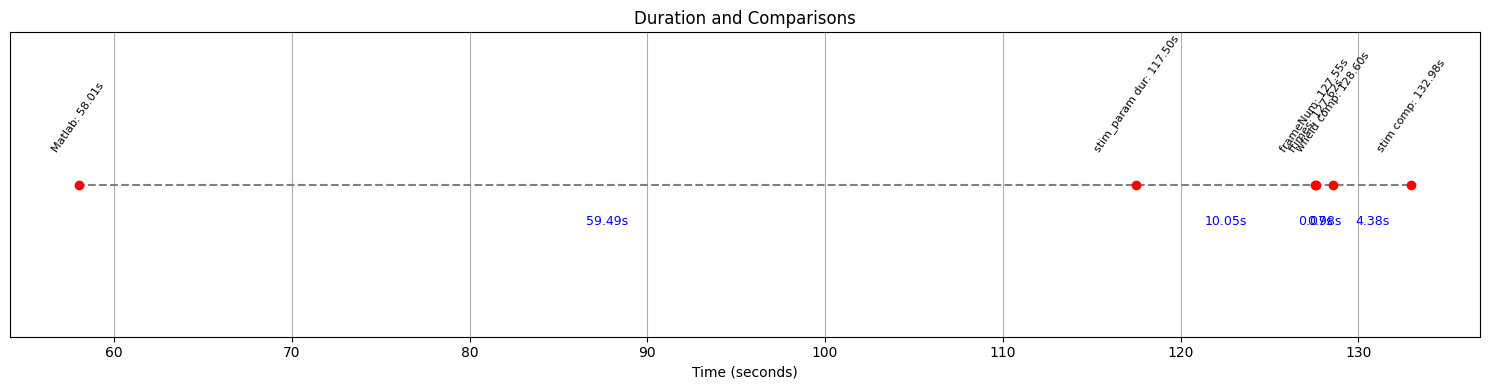

In [18]:
# analyzing experiment duration 

if ELAPSED_TIME != None: print(f"Matlab elapsed time: {ELAPSED_TIME}s")

# determine the total time based on frame times
if blue_fTimes[0] < violet_fTimes[0]:
    first_frame_time = blue_fTimes[0]  
else: first_frame_time = violet_fTimes[0]

if blue_fTimes[-1] > violet_fTimes[-1]:
    last_frame_time = blue_fTimes[-1]  
else: last_frame_time = violet_fTimes[-1]

elapsed_ftimes = (last_frame_time - first_frame_time).total_seconds()
print(f"\nFrame_times elapsed time: {elapsed_ftimes}s")

# determine the theoretical total frame time from number of frames
total_frame_count = blue_frames.shape[0] + violet_frames.shape[0]
elapsed_frames = total_frame_count * (1/CAMERA_HZ)
print(f"Number of frames theoretical duration: {elapsed_frames}s")

print(f"\nElapsed time based on wfield computer data: {analog_x_values[-1]}s")
print(f"Elapsed time based on stim computer data: {stim_x_values[-1]}s")
print(f"Difference in wfield vs stim comp exp length: {stim_x_values[-1] - analog_x_values[-1]}s")

print(f"\nstim_params['duration']: {stim_params['duration']}s")

# ------------------------------------------- #
if ELAPSED_TIME != None:
    time_points = [ELAPSED_TIME, elapsed_ftimes, elapsed_frames, analog_x_values[-1], stim_x_values[-1], stim_params['duration']]
    time_labels = ["Matlab", "ftimes", "frameNum", "wfield comp", "stim comp", "stim_param dur"]
else:
    time_points = [elapsed_ftimes, elapsed_frames, analog_x_values[-1], stim_x_values[-1], stim_params['duration']]
    time_labels = ["ftimes", "frameNum", "wfield comp", "stim comp", "stim_param dur"]

# Ensure inputs are sorted by time 
sorted_points = sorted(zip(time_points, time_labels))
time_points, labels = zip(*sorted_points)

# Plot a horizontal line
plt.figure(figsize=(15, 4))
plt.hlines(0, min(time_points) - 0.1, max(time_points) + 0.1, color='gray', linestyle='--')

# Plot each point and add labels
for i, (time, label) in enumerate(zip(time_points, labels)):
    plt.plot(time, 0, 'ro')  # Red dot at each time point
    plt.text(time, 0.1, f"{label}: {time:.2f}s", ha='center', va='bottom', rotation=55, fontsize=8)

    # Add distance labels between consecutive points
    if i > 0:
        distance = time - time_points[i - 1]
        midpoint = (time + time_points[i - 1]) / 2
        plt.text(midpoint, -0.1, f"{distance:.2f}s", ha='center', va='top', fontsize=9, color='blue')

# Adjust plot limits and appearance
plt.ylim(-0.5, 0.5)
plt.xlabel("Time (seconds)")
plt.yticks([])  # Hide y-axis ticks
plt.title("Duration and Comparisons")
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
if DATA_FORMAT == "OLD":    # we have access to the start time of both computers 
    # Let's first compare the experiment start times between the two computers
    analog_onset = analog_onset

    stim_onset = datetime.datetime.fromtimestamp(stim_experiment_start_timestamp)
    print(f"Wfield comp onset: {analog_onset}")
    print(f"Stim comp onset: {stim_onset}")

    STIM_FIRST = stim_onset < analog_onset

    print(f"The stimulus computer onset time is earlier than the wfield computer by {(analog_onset - stim_onset).total_seconds()}s") if STIM_FIRST else print(f"The wfield computer onset time is earlier than the stim computer by {(stim_onset - analog_onset).total_seconds()}s")

    # TODO: Here we notice that the time in aquisition is different.
    '''# We want to figure out this difference, before we do anything
    print('Time in ms that TTL Widefield Acquisition was on for ' + str(len(wf_m_blueLED)) + 'ms')
    print('Time in ms that Frames were captured for ' + str((blue_frames.shape[0]/CAMERA_HZ) * 1000 * 2) + 'ms')
    print(f"what is this gap of {len(wf_m_blueLED) - ((blue_frames.shape[0]/CAMERA_HZ) * 1000 * 2)}ms?")
    # see if gap can be accounted for by the '''

elif DATA_FORMAT == "NEW": 
    print("This data was collected on or after February 14th 2025. \nBecuase we no longer have access to the stim computer start time variable, this cell is being skipped.")

Wfield comp onset: 2025-01-08 17:00:46.066682
Stim comp onset: 2025-01-08 17:00:45.932799
The stimulus computer onset time is earlier than the wfield computer by 0.133883s


# Alignment

Our main goal is to align the camera frames (and their corresponding frame times) with the stimulus pulses such that we can extract the frames that correspond to different stimulus presentations or trials. 

** A subsequent goal would be to align the blue-violet camera led ttl pulses with the frames 

We have access to the following data to help us:
- From the wfield/analog computer:
    - Camera frames and camera frame times (unsure which time but surely the wfield comp time)
    - Stimulus presentation rising edge ttl pulses (but no associated time)
    - Widefield comp experimental start time
- From the stimulus computer:
    - Stimulus comp experimental start time
    - Stimulus presentation rising edge ttl pulses (and associated time)
        - ** We have two of these that have a slight delay. 


1. alignment of the stop time to the -5 or -6 blue or violet dark frame
2. alignment of the stim LED times with the camera frames 
3. index alignment with the end of the analog stim to the frame times

## Alignment Method 1: Time-based

One alignment method disregards the timestamps and works only with indices. 
Another alignment method works mostly with the timestamps provided. 

The main question here is the following: what aligns with what?

The following methods use functions made to operate independently of the above code. As such, these can be used in the main pipeline to select the desired and standardized alignment option.
- alignments called with functions *alignment_1_#* return tuples containing datetime.datetime tuples
- alignments called with functions *alignment_2_#* return tuples containing index tuples 

In [33]:
seconds_before_stim = 1
seconds_after_stim = 2
alignment_func = alignment_1_2

show_frames = True # set to true to see the average frames for a trial

if DATA_FORMAT == "OLD":
    computer_time_diff = (analog_onset - stim_onset).total_seconds()
    print(f"start time diff between computers: {computer_time_diff}s")
    print(f"mean shift between stim and analog comp: {mean_shift}s")
    print(f"comp dist: {comp_dist}")
if DATA_FORMAT == "NEW":
    computer_time_diff = comp_dist

start time diff between computers: 0.133883s
mean shift between stim and analog comp: 1.023253846153847s
comp dist: 0.030555999999998775


In [36]:
plt.figure(figsize=(15, 5))
plt.title(f"Alignment Method: {str(alignment_func).split(" ")[1]}\nAdjusted Stim LED Times vs Mean Frame Values")

if alignment_func in [alignment_2_2, alignment_2_1]:
    x_blue = np.arange(blue_frames.shape[0]) / (CAMERA_HZ/2)
    x_violet = (np.arange(violet_frames.shape[0]) / (CAMERA_HZ/2)) + 1/(CAMERA_HZ/2) 
    plt.scatter(x_violet, normalized_violet_mean, s=5, color = 'purple', label=f"Normalized violet frames")
    plt.plot(x_violet, normalized_violet_mean, linewidth=0.5, color = 'purple')
    plt.scatter(x_blue, normalized_blue_mean, s=5, color = 'royalblue', label=f"Normalized blue frames")
    plt.plot(x_blue, normalized_blue_mean, linewidth=0.5, color = 'royalblue')

    x_values_alignment = alignment_func(EXPERIMENT_PATH, STIM_TYPE, blue_frames.shape[0], 40)
else:
    plt.scatter(violet_fTimes, normalized_violet_mean, s=5, color = 'purple', label=f"Normalized violet frames")
    plt.plot(violet_fTimes, normalized_violet_mean, linewidth=0.5, color = 'purple')
    plt.scatter(blue_fTimes, normalized_blue_mean, s=5, color = 'royalblue', label=f"Normalized blue frames")
    plt.plot(blue_fTimes, normalized_blue_mean, linewidth=0.5, color = 'royalblue')
    x_values_alignment = alignment_func(EXPERIMENT_PATH, STIM_TYPE)

for i in range(len(x_values_alignment)):  # Iterate over start-stop pairs
    start = x_values_alignment[i][0] # the following has been added to the alignment_1_1 function: - timedelta(seconds = computer_time_diff)
    stop = x_values_alignment[i][1] # the following has been added to the alignment_1_1 function: - timedelta(seconds = computer_time_diff)
    plt.axvspan(start, stop, color='gray', alpha=0.3, label="Stim Computer Stim on" if i == 0 else None)

plt.legend()
plt.show()

if alignment_func in [alignment_2_2, alignment_2_1]:
    adjusted_tuples = [(start - seconds_before_stim, end + seconds_after_stim) for start, end in x_values_alignment]
else:
    adjusted_tuples = [(start - timedelta(seconds=seconds_before_stim), end + timedelta(seconds=seconds_after_stim)) for start, end in x_values_alignment]

# Initialize a list to store extracted data for each interval
stacked_data = []
trial_lengths = []
frame_trials = []

# Loop through each interval
for start, end in adjusted_tuples:
    # Find indices corresponding to the interval
    start_idx, end_idx = 0, 0
    if alignment_func in [alignment_2_2, alignment_2_1]:
        start_idx = np.searchsorted(x_blue, start)
        end_idx = np.searchsorted(x_blue, end) # index of first frame after trial region
    else:
        start_idx = np.searchsorted(blue_fTimes[:-1], start)
        end_idx = np.searchsorted(blue_fTimes[:-1], end) # index of first frame after trial region
    
    # Extract the data for the interval and append to the list
    trial_data = normalized_blue_mean[start_idx:end_idx]
    stacked_data.append(trial_data)
    trial_lengths.append(len(trial_data))

    frame_trials.append(blue_frames[start_idx:end_idx, ...])

# Align the stacked data
print(f"Frames per trial block:{trial_lengths}")

# Check that all trials are the same length. If not add NAN values to prevent errors down the line. 
max_length = max(map(len, stacked_data))
# Create a NaN-filled array of shape (num_trials, max_length)
padded_data = np.full((len(stacked_data), max_length), np.nan)
# Copy data into the NaN array
for i, row in enumerate(stacked_data):
    padded_data[i, :len(row)] = row  # Fill in available data

trial_time = 0 
if alignment_func in [alignment_2_2, alignment_2_1]:
    trial_time = adjusted_tuples[0][1] - adjusted_tuples[0][0]
else:
    trial_time = (adjusted_tuples[0][1] - adjusted_tuples[0][0]).total_seconds()

print(f"Trial duration: {trial_time}s")
#x_time = np.linspace(-seconds_before_stim, seconds_after_stim, trial_lengths[0])
x_time = np.linspace(0, trial_time, max_length)

# Plot the stacked data
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
for i, region in enumerate(stacked_data):
    plt.plot(x_time[:len(region)], region, linewidth=0.5, label=(f"Mean trial signals"  if i == 0 else None))
    plt.scatter(x_time[:len(region)], region, s=3)

if STIM_TYPE == "LED":
    plt.axvspan(seconds_before_stim, seconds_before_stim+stim_time, color='red', alpha=0.3, label="Stim LED on")
elif STIM_TYPE == "OLFAC":
    plt.axvspan(seconds_before_stim, seconds_before_stim+stim_configs['experiment_config']['ODOR_DURATION'], color='red', alpha=0.3, label="Stim ODOR delivery")

plt.title("Comparison of Gray-Shaded Regions")
plt.xlabel("Time sec. (relative to stim start)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
if STIM_TYPE == "LED":
    plt.axvspan(seconds_before_stim, seconds_before_stim+stim_time, color='red', alpha=0.3, label="Stim LED on")
elif STIM_TYPE == "OLFAC":
    plt.axvspan(seconds_before_stim, seconds_before_stim+stim_configs['experiment_config']['ODOR_DURATION'], color='red', alpha=0.3, label="Stim ODOR delivery")

plt.scatter(x_time, np.nanmean(padded_data, axis=0), s=3, label=f"Mean trial signal")
plt.plot(x_time, np.nanmean(padded_data, axis=0), linewidth=0.5)

plt.title("Mean response over a trial")
plt.xlabel("Time sec. (relative to stim start)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

if show_frames:
    # pad data with nan as necessary
        # find the max number of frames
    max_frames = max(img_stack.shape[0] for img_stack in frame_trials)

    H = frame_trials[0].shape[1]
    W = frame_trials[0].shape[2]

    # Pre-allocate a NaN-filled array of shape (trialNum, frameNum, H, W)
    padded_data = np.full((len(frame_trials), max_frames, H, W), np.nan)

    # Copy data into the pre-allocated array
    for i, img_stack in enumerate(tqdm(frame_trials, desc="Padding frame array")):
        padded_data[i, :img_stack.shape[0], :, :] = img_stack  # Fill with existing frames

    print(f"Padded frame trials shape: {padded_data.shape}")

    mean_trial_frames = np.nanmean(padded_data, axis=0)

    # LED
    fig, axs = plt.subplots(4,10, figsize=(18,7))

    for i, ax in enumerate(axs.flatten()):
        ax.imshow(mean_trial_frames[i])
        ax.set_title(str(i+1))
        ax.set_xticks([]) 
        ax.set_yticks([])

    plt.show()

Frames per trial block:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Trial duration: 3.5s


Padding frame array: 100%|██████████| 10/10 [00:00<?, ?it/s]

Padded frame trials shape: (10, 0, 640, 540)


IndexError: index 0 is out of bounds for axis 0 with size 0

Trial duration: 3.5s


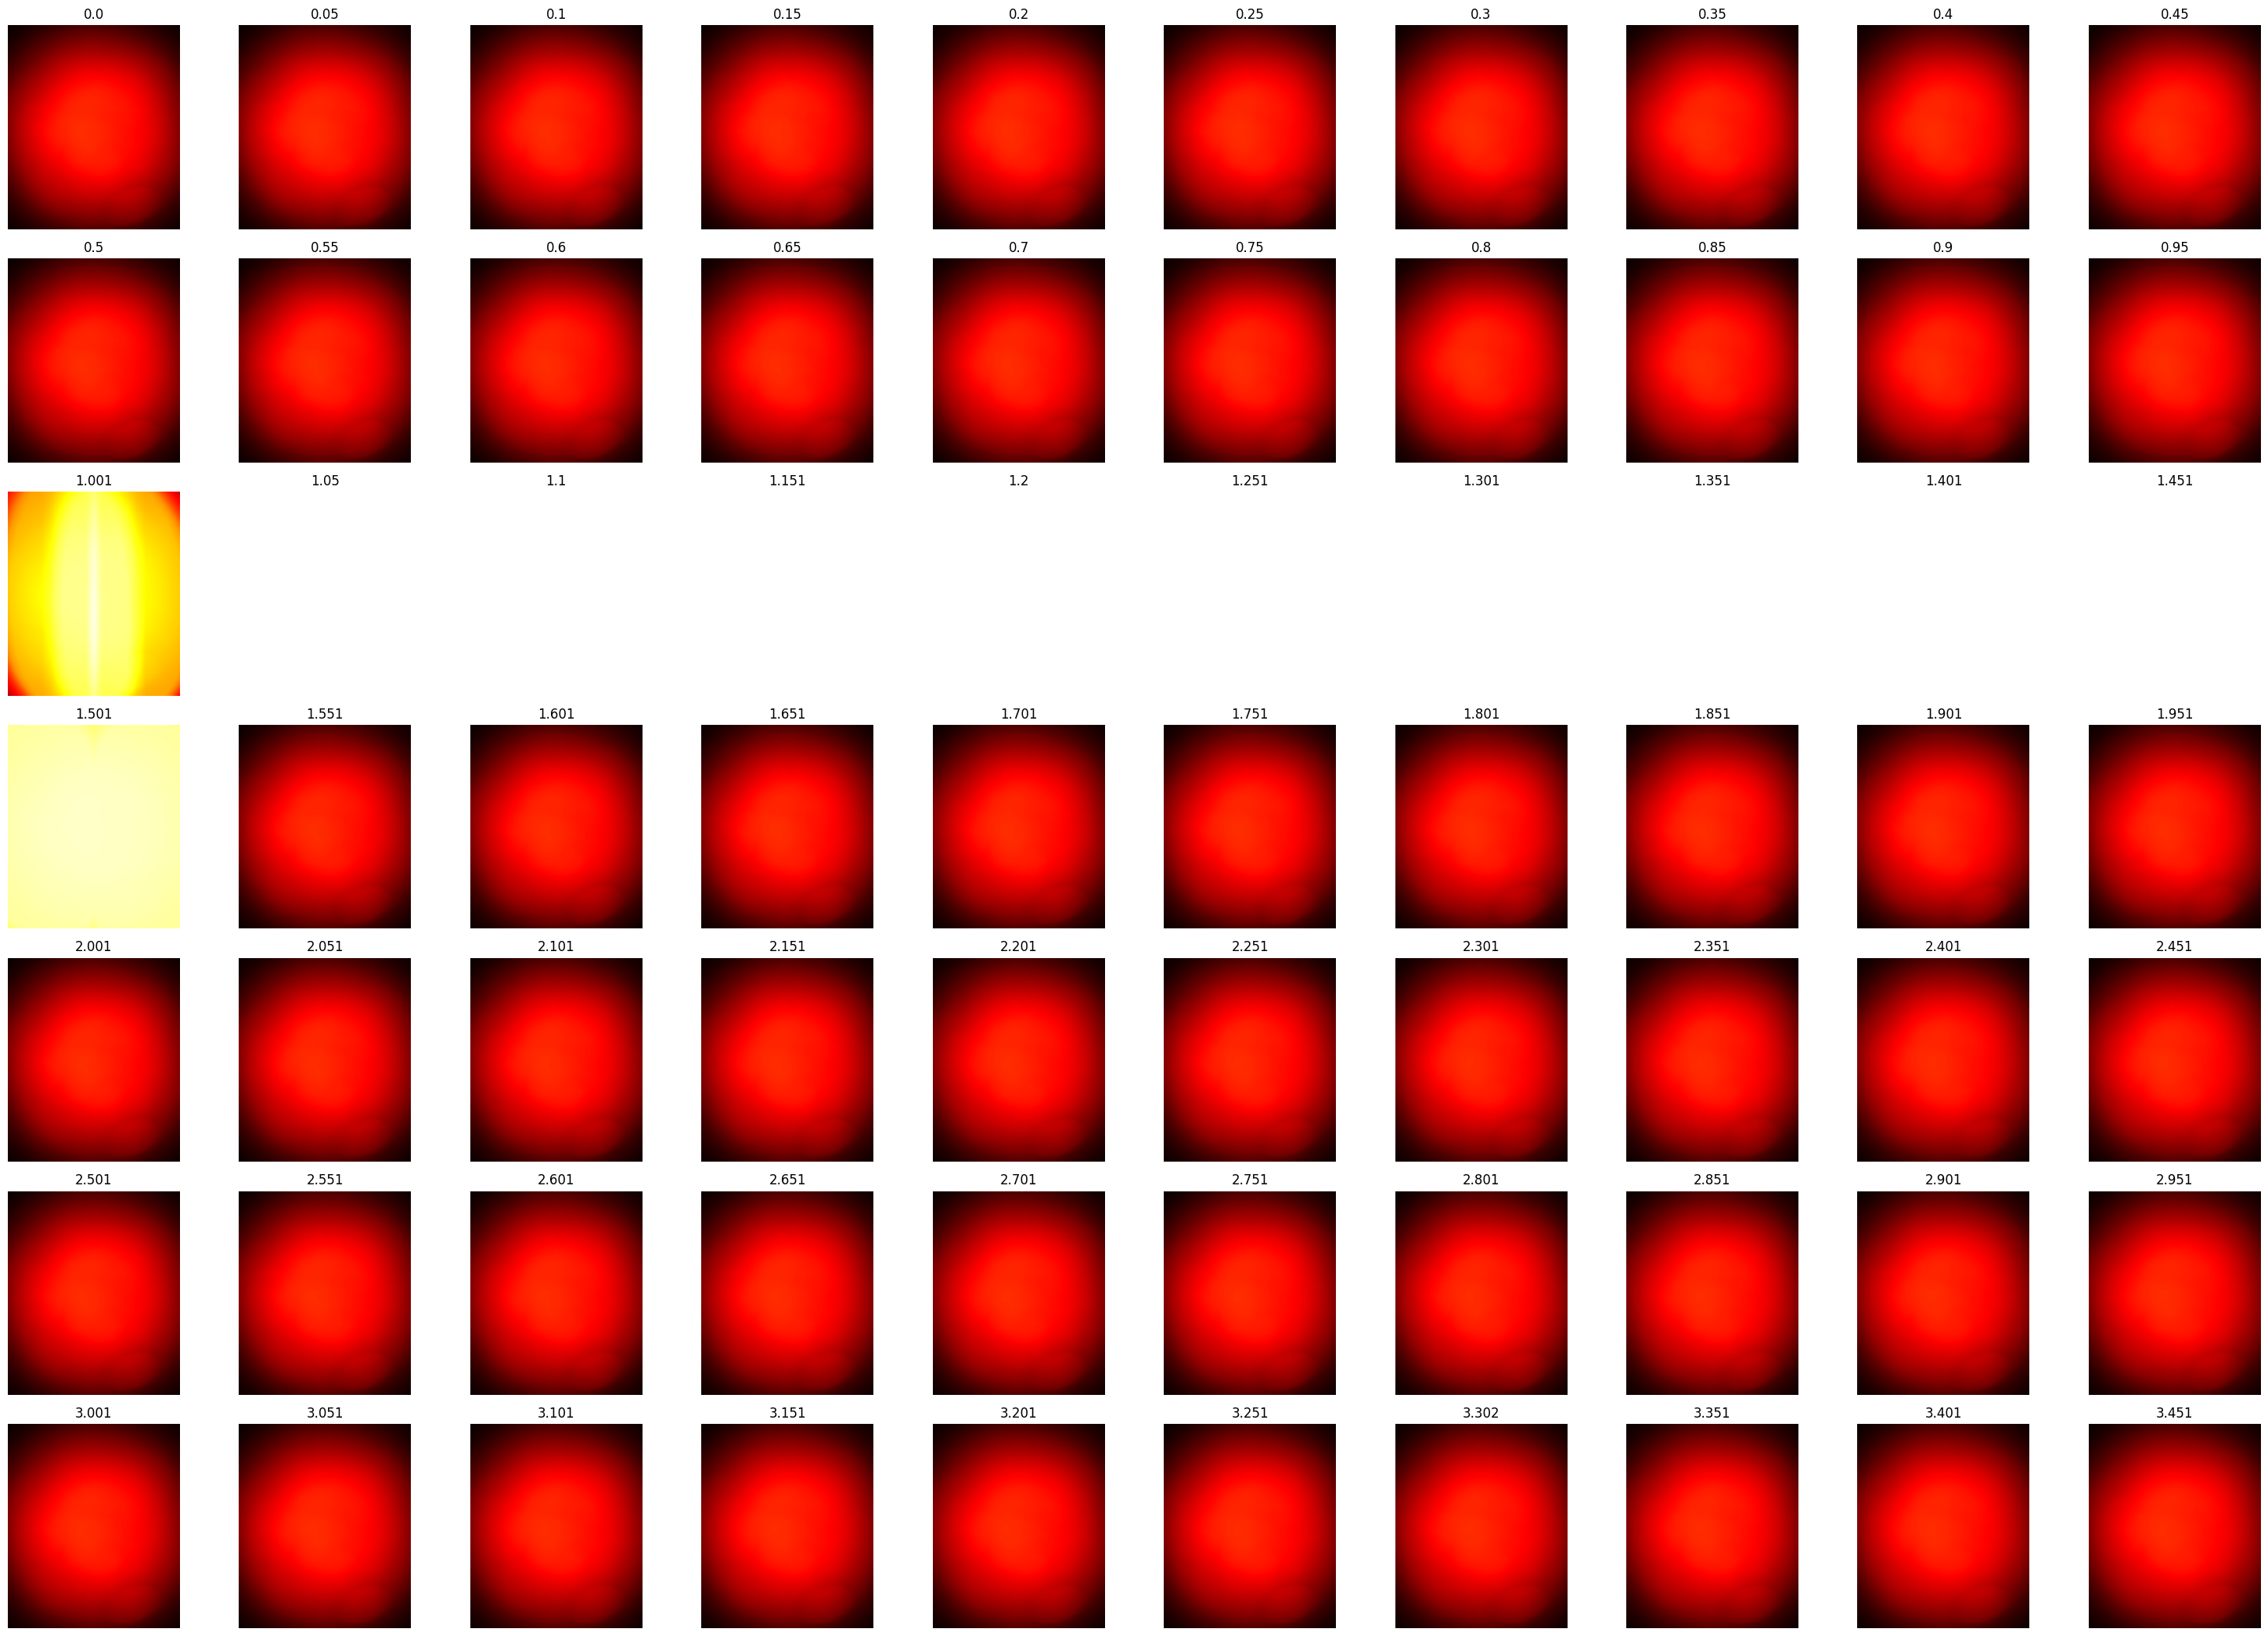

In [22]:
frameTimeMat_path = r"F:\wfield\oldType_testData\LED\frameTimes_0001.mat"
EXPERIMENT_PATH = r"F:\wfield\oldType_testData\LED"
STIM_TYPE = "LED"
alignment_func = alignment_1_2

frames = load_dat_frames(get_exp_file_path(EXPERIMENT_PATH, 'F'))
blue_darkFrame_num, violet_darkFrame_num = get_darkFrame_num(frames, threshold=0.3)
frames_array = frames[:,0,:,:]
violet_frames = frames[:,1,:,:]
del frames

stim_times_array = alignment_func(EXPERIMENT_PATH, STIM_TYPE)
pre_post_stim = (1,2)

# extract frameTimes .mat file data
ftimes, _ = get_frameTime_data(frameTimeMat_path, returnType="datetime")
blue_ftimes = ftimes[0]

# if there are more frameTimes than frames, shorten the frameTime array from the end
if len(blue_ftimes) > frames_array.shape[0]:
    blue_ftimes = blue_ftimes[:frames_array.shape[0]]

adjusted_tuples = np.array([(start - timedelta(seconds=pre_post_stim[0]), end + timedelta(seconds=pre_post_stim[1])) for start, end in stim_times_array])

# Initialize a list to store extracted data for each interval
trial_lengths = []
frame_trials = []
trial_times = []

baseline_nums = []
# Loop through each interval
for i, (start, end) in enumerate(adjusted_tuples):
    # Find indices corresponding to the interval
    start_idx = np.searchsorted(blue_ftimes, start)
    end_idx = np.searchsorted(blue_ftimes, end) # index of first frame after end of prev trial region
    
    # Extract the data for the interval and append to the list
    time_data = blue_ftimes[start_idx:end_idx]
    trial_data = normalize_arr(frames_array[start_idx:end_idx][:])

    frame_trials.append(trial_data)
    
    trial_times.append(time_data)
    trial_lengths.append(len(trial_data))


# find the max number of frames
mode_frame_num = (stats.mode(trial_lengths))[0]
trial_lengths = np.array(trial_lengths)

# check if all trial lengths are equal
if not np.all(trial_lengths == mode_frame_num):
    # remove trials that have less frames 
    indicies_remove = np.array(*np.where(trial_lengths != mode_frame_num))
    # remove trial from trial_lengths, trial_times, frame_trials, baseline_nums
    trial_lengths = np.delete(trial_lengths, indicies_remove)
    stim_times_array = np.delete(stim_times_array, indicies_remove, axis=0)
    adjusted_tuples = np.delete(adjusted_tuples, indicies_remove, axis=0)

    clean_trial_times = []
    clean_frame_trials = []
    for i in range(len(trial_times)):
        if i not in indicies_remove:
            clean_trial_times.append(trial_times[i])
            clean_frame_trials.append(frame_trials[i])
    
    trial_times = np.array(clean_trial_times)
    frame_trials = np.array(clean_frame_trials)
else:
    trial_times = np.array(trial_times)
    
mean_trial_frames = np.nanmean(np.array(frame_trials), axis=0)

centered_trial_times = np.empty(trial_times.shape)
for trial_num, trial_data in enumerate(trial_times):
    start = trial_data[0]
    for i in range(len(trial_data)):
        d = trial_data[i] - start
        centered_trial_times[trial_num][i] = d.total_seconds()

average_times = np.mean(centered_trial_times, axis=0)

trial_time = (adjusted_tuples[0][1] - adjusted_tuples[0][0]).total_seconds()
print(f"Trial duration: {trial_time}s")
trial_xTime = average_times # x-axis time in seconds

# organize the frames on a single image
cols = 10  
rows = mode_frame_num // 10 

fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

axs = axs.flatten()  # Flatten for easy indexing
minVal = np.nanmin(mean_trial_frames)
maxVal = np.nanmax(mean_trial_frames)
for i in range(mode_frame_num):
    axs[i].imshow(mean_trial_frames[i], cmap='hot', vmin=minVal, vmax=maxVal) 
    axs[i].set_title(str(round(trial_xTime[i], 3)))
    axs[i].axis('off')  # Remove axis ticks

# Hide any unused subplots
for i in range(mode_frame_num, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


In [23]:
a = 1.1292090909090915
b = 0.02795000000000041
c = 0.465035

# we need to add around 0.35 s 
# how can we get this number ? 
d = a-b
print(d)

1.1012590909090911


(10, 70)


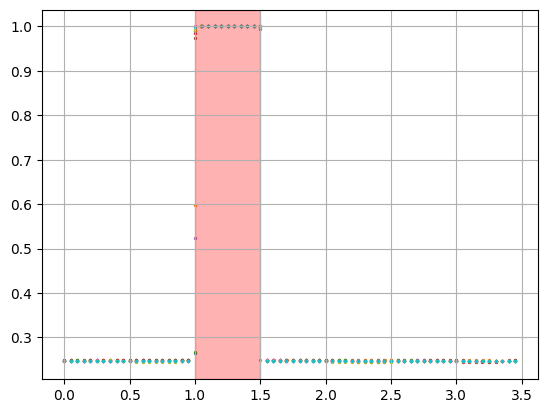

In [24]:
mean_values = np.mean(np.array(frame_trials), axis=(2,3))
print(mean_values.shape)

for i in range(len(centered_trial_times)):
    plt.scatter(centered_trial_times[i], mean_values[i], s=2)
plt.axvspan(1,1.5, color='red', alpha=0.3, label="Stim on")
plt.grid()
plt.show()

***
# Check the validity of the alignment:

ie. check the following:
- on average how many frames is the alignment off by 
- how many frames total is the alignment off by
- is there a time dependent delay in the alingment ? 

- check that there are 80 frames before the exp start mark 
- also make sure that the blue and violet LEDs are properly aligned to the actual frame capture points

***
# For Data: Rotary Only

.mat file and Hdf5 file only

In [25]:
%matplotlib qt
#%matplotlib inline

import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle
import datetime
from utils import normalize_arr

mat_file_path = r"D:\wfield\vanessa_rotary_encoder_wfield\march_05_TEST\data_test_OlfactometerStimulusProtocol_202503051648405_mat.mat"
data = scipy.io.loadmat(mat_file_path, simplify_cells=True)

ModuleNotFoundError: No module named 'utils'

The HDF5 file is identical to the matlab file but simply stores the variables in a different format. In the below code, we will only explore the matlab file. 

The matlab file contains the following data keys: 

## *These can be ignored*:
| ||
|------|---------|
| '__header__'|contains matlab version and the exp date / time|
|'__version__'|single number indicating the version|
|'__globals__' |contains an empty list|
|**'software_environment'**|contains the 'source_code'|
|**'stimulus_frame_info_text'**|contains the same data as 'stimulus_frame_info' but in a different format|
|**'sync'**|contains the same info as 'sync_sc' but takes up more space / has larger data types|
|**'sync_scaling'**|contains three variables (offset, range, scale)|


## *These contain important 'per-run' variables*:

### 'configs'
|Configs Key|Inner variables|
|------|---------|
|['experiment_config']| ['ODORS', 'ODOR_EXPECTED_SIDE', 'PATTERNS', 'ENABLE_BEEP', 'ENABLE_OLFACTO', 'ENABLE_SNAP_STIM', 'ENABLE_TONE', 'GAUSSIAN_BLUR_RADIUS', 'GAUSSIAN_BLUR_SIGMA', 'MIX_DURATION', 'NI_DEVICE', 'ODOR_DURATION', 'STEER_DEGREE_FOR_REWARD', 'TONE_DURATION', 'TONE_FREQUENCY', 'TONE_UPDATE_RATE', 'WHEEL_SIGNAL_MOVING_AVERAGE_WINDOW']|
|['machine_config']|['BACKGROUND_COLOR', 'CONNECTIONS', 'DIGITAL_IO_PORT', 'DISPLAY_INTENSITIES', 'GAMMA_CORRECTION_CURVE', 'KEYS', 'MENU_POSITION', 'MESSAGE_POSITION', 'ORIGO', 'SCREEN_CENTER', 'SCREEN_POSITION', 'SCREEN_RESOLUTION', 'SCREEN_SIZE_UM', 'SETUP_SETTINGS', 'TEXT_COLOR', 'UPPER_LEFT_CORNER', 'USER_INTERFACE_NAMES', 'WIDEFIELD_START_PINS', 'WIDEFIELD_STOP_PINS', 'ACQUISITION_STOP_PIN', 'ACQUISITION_TRIGGER_PIN', 'ACQUISITION_TRIGGER_POLARITY', 'ALTERNATIVE_TIMING', 'BACKUPTIME', 'BASE_PORT', 'BLOCK_TIMING_PIN', 'BLOCK_TRIGGER_PULSE_WIDTH', 'BULLSEYE_FILE', 'CAM1FILENAME_TAG', 'CAMERA_API', 'CAMERA_PRETRIGGER_TIME', 'CAMERA_START_TIME', 'CAMERA_TRIGGER_ENABLE', 'CHECK_STIMULUS_DURATION', 'CONTEXT_PATH', 'COORDINATE_SYSTEM', 'DATA_READY_TIMEOUT', 'DEFAULT_CAMERA_FRAME_RATE', 'DIGITAL_IO_PORT_TYPE', 'ENABLE_BATCH_EXPERIMENT', 'ENABLE_CHECK_ABORT', 'ENABLE_EYE_CAMERA', 'ENABLE_FILE_TRIGGER', 'ENABLE_FRAME_CAPTURE', 'ENABLE_OPENEPHYS_TRIGGER', 'ENABLE_SHUTTER', 'ENABLE_STIM_UDP_TRIGGER', 'ENABLE_SYNC', 'ENABLE_TEXT', 'ENABLE_TIME_INDEXING', 'ENABLE_TSIM_CHECK', 'ENABLE_USER_FOLDER', 'EXPERIMENT_DATA_PATH', 'EXPERIMENT_FILE_FORMAT', 'EXPERIMENT_MAXIMUM_DURATION', 'FILE_TRIGGER_PATHS', 'FLIP_EXECUTION_TIME', 'FRAME_RATE_ERROR_THRESHOLD', 'FRAME_RATE_TOLERANCE', 'FRAME_TIMING_PIN', 'FRAME_TIMING_PULSE_WIDTH', 'FRAME_WAIT_FACTOR', 'FREE_SPACE_ERROR_THRESHOLD', 'FREE_SPACE_WARNING_THRESHOLD', 'FULLSCREEN', 'GUI_HEIGHT', 'GUI_POS_X', 'GUI_POS_Y', 'GUI_WIDTH', 'HORIZONTAL_AXIS_POSITIVE_DIRECTION', 'IMAGE_DIRECTLY_PROJECTED_ON_RETINA', 'INSERT_FLIP_DELAY', 'IS64BIT', 'LOG_PATH', 'MAXIMUM_RECORDING_DURATION', 'MAX_MESSAGE_LENGTH', 'MEASURE_FRAME_RATE', 'MOUSE_1_VISUAL_DEGREE_ON_RETINA', 'NETWORK_COMMUNICATION_TIMEOUT', 'NI_DEVICE', 'NSCREENS', 'NUMBER_OF_MESSAGE_ROWS', 'OS', 'PACKAGE_PATH', 'PLATFORM', 'SCREEN_ANGLE_RANGE', 'SCREEN_CENTER_ADJUST_STEP_SIZE', 'SCREEN_DISTANCE_FROM_MOUSE_EYE', 'SCREEN_EXPECTED_FRAME_RATE', 'SCREEN_MODE', 'SCREEN_PIXEL_TO_UM_SCALE', 'SCREEN_PIXEL_WIDTH', 'SCREEN_UM_TO_PIXEL_SCALE', 'SCREEN_WIDTH', 'STIMULATION_AND_IMAGING_START_TIMEOUT', 'STIMULUS2MEMORY', 'STIM_RECORDS_ANALOG_SIGNALS', 'STIM_START_TRIGGER_PIN', 'STIM_SYNC_CHANNEL_INDEX', 'SYNC_RECORDER_CHANNELS', 'SYNC_RECORDER_SAMPLE_RATE', 'SYNC_SIGNAL_MIN_AMPLITUDE', 'TSTIM_SYNC_INDEX', 'VALVE_CONTROL_CHANNEL', 'VALVE_CONTROL_VOLTAGE', 'VERTICAL_AXIS_POSITIVE_DIRECTION', 'VISUAL_ANGLE_TO_UM_SCALE', 'WAIT4TRIGGER_ENABLED', 'user']|
|['serialized']| can be ignored as it contains the same information as above in 'machine_config'|
|['hash']| can also be ignored |


In [ ]:
# Explore the noteworthy config-file variables

# Experiment configs
experiment_configs = data['configs']['experiment_config']
print(f"-----------------------EXPERIMENT CONFIGS-----------------------")
print(f"ODORS: {experiment_configs['ODORS']}")
print(f"ODOR_EXPECTED_SIDE: {experiment_configs['ODOR_EXPECTED_SIDE']}")
print(f"PATTERNS: {experiment_configs['PATTERNS']}")
print(f"MIX_DURATION: {experiment_configs['MIX_DURATION']}")
print(f"ODOR_DURATION: {experiment_configs['ODOR_DURATION']}")
print(f"STEER_DEGREE_FOR_REWARD: {experiment_configs['STEER_DEGREE_FOR_REWARD']}")

# Machine configs
machine_configs = data['configs']['machine_config']
print(f"\n-----------------------MACHINE CONFIGS-----------------------")
print(f"STIM_SYNC_CHANNEL_INDEX: {machine_configs['STIM_SYNC_CHANNEL_INDEX']}")
print(f"SYNC_RECORDER_SAMPLE_RATE: {machine_configs['STIM_SYNC_CHANNEL_INDEX']}")
print(f"TSTIM_SYNC_INDEX: {machine_configs['TSTIM_SYNC_INDEX']}")

### 'parameters'

Contains the following keys: 

['Animal', 'Beep_Duration', 'Beep_Frequency', 'Beep_duration', 'Beep_frequency', 'Bullseye_On', 'Bullseye_Shape', 'Bullseye_Size', 'Bullseye_on', 'Bullseye_shape', 'Bullseye_size', 'Duration', 'Enable_Psychotoolbox', 'Enable_Widefield', 'Enable_psychotoolbox', 'Enable_widefield', 'Eyecamfilename', 'Grey_Level', 'Grey_level', 'Hold_Stable_at_Reward', 'Hold_stable_at_reward', 'Id', 'Intertrial_Wait', 'Intertrial_wait', 'Machine_config', 'Main_Tab', 'Main_tab', 'Max_trials', 'Name', 'Noise_Duration', 'Noise_duration', 'Olfacto_Stimulus_Duration', 'Olfacto_stimulus_duration', 'Outfilename', 'Outfolder', 'Record_Eyecamera', 'Record_eyecamera', 'Region_name', 'Repeat_until_correct', 'Restrict_Stimulus_Side', 'Restrict_stimulus_side', 'Reward_Delay', 'Reward_Stimulus_Ratio', 'Reward_Zone_Tolerance', 'Reward_delay', 'Reward_stimulus_ratio', 'Reward_zone_tolerance', 'Selected_experiment_class', 'Snap_Time', 'Snap_time', 'Spatial_Frequency', 'Spatial_frequency', 'Status', 'Step_Size', 'Step_size', 'Stimclass', 'Stimfile', 'Stimulus_Background_Color', 'Stimulus_Center_X', 'Stimulus_Center_Y', 'Stimulus_Size', 'Stimulus_background_color', 'Stimulus_center_x', 'Stimulus_center_y', 'Stimulus_size', 'Stimulus_source_code', 'Trial_Time', 'Trial_time', 'Trials', 'User', 'Valve_Open_Time', 'Valve_open_time', 'Wheel_Stable_Time', 'Wheel_stable_time', 'animal', 'duration', 'eyecamfilename', 'id', 'machine_config', 'name', 'outfilename', 'outfolder', 'partial_data', 'region_name', 'status', 'stimclass', 'stimfile', 'stimulus_source_code', 'user']




In [ ]:
# Look at noteworthy parameter variables
parameters = data['parameters']

print(f"\n-----------------------PARAMETERS-----------------------")
print(f"Intertrial_Wait: {parameters['Intertrial_Wait']}")
#print(f"Intertrial_wait: {parameters['Intertrial_wait']}")

print(f"Max_trials: {parameters['Max_trials']}")

print(f"Olfacto_Stimulus_Duration: {parameters['Olfacto_Stimulus_Duration']}")
#print(f"Olfacto_stimulus_duration: {parameters['Olfacto_stimulus_duration']}")

print(f"Repeat_until_correct: {parameters['Repeat_until_correct']}")

print(f"Reward_Delay: {parameters['Reward_Delay']}")
#print(f"Reward_delay: {parameters['Reward_delay']}")

print(f"Reward_Stimulus_Ratio: {parameters['Reward_Stimulus_Ratio']}")
#print(f"Reward_stimulus_satio: {parameters['Reward_stimulus_ratio']}")

print(f"Reward_Zone_Tolerance: {parameters['Reward_Zone_Tolerance']}")
#print(f"Reward_zone_tolerance: {parameters['Reward_zone_tolerance']}")

print(f"Trial_Time: {parameters['Trial_Time']}")
#print(f"Trial_time: {parameters['Trial_time']}")

print(f"Trials: {parameters['Trials']}")

print(f"Valve_Open_Time: {parameters['Valve_Open_Time']}")
#print(f"Valve_open_time: {parameters['Valve_open_time']}")
print(f"Wheel_Stable_Time: {parameters['Wheel_Stable_Time']}")
print(f"Wheel_stable_time: {parameters['Wheel_stable_time']}")


### 'stimulus_frame_info'

Contains information about the actual trials and odors delivered.  
For each trial or block, there are 5 cells 
1. contains the block_start index, and block_start time
2. contains the odor start time
3. parameters: odor duration in ms, odorname, and the time (unsure which time this refers to)
4. contains the block_end index and corresponding time 

we will store this information in the following way, one per trial block
{trial_start: [index, time], odor: [odor_str, start_time, duration, stop_time], trial_stop: [index, time]}

### 'sync_sc'

In [ ]:
# Explore the stimulus frame info variable

print(f"Length of 'stimulus_frame_info': {len(data['stimulus_frame_info'])}")
print(f"\nSince we only had {parameters['Max_trials']} trials, this means we have {len(data['stimulus_frame_info'])/parameters['Max_trials']} cells per trial")

stim_frame_info = []

indices_st = []
time_st = []
odor_time_st = []

for trial_i in range(int(parameters['Max_trials'])):
    start_i = trial_i * 5
    start_index = data['stimulus_frame_info'][start_i]['block_start']
    indices_st.append(start_index)
    start_time = datetime.datetime.fromtimestamp(data['stimulus_frame_info'][start_i]['time'])
    time_st.append(start_time)
    odor_start = datetime.datetime.fromtimestamp(data['stimulus_frame_info'][start_i+1]['time'])
    odor_time_st.append(odor_start)
    odor_str = data['stimulus_frame_info'][start_i+2]['parameters']['odorname']
    odor_dur = data['stimulus_frame_info'][start_i+2]['parameters']['duration']
    odor_stop = datetime.datetime.fromtimestamp(data['stimulus_frame_info'][start_i+3]['time'])
    odor_time_st.append(odor_stop)
    stop_index = data['stimulus_frame_info'][start_i+4]['block_end']
    indices_st.append(stop_index)
    stop_time = datetime.datetime.fromtimestamp(data['stimulus_frame_info'][start_i+4]['time'])
    time_st.append(stop_time)

    stim_frame_info.append({'trial_start': [start_index, start_time], 'odor': [odor_str, odor_start, odor_stop, odor_dur], 'trial_stop': [stop_index, stop_time]})

plt.figure(figsize=(17, 7))

plt.subplot(2, 1, 1)
plt.title("Index domain first 10 trials")
for i in range(0, 10, 2):  # Step by 2 to get pairs
    start = indices_st[i]
    stop = indices_st[i+1]
    plt.axvspan(start, stop, color='black', alpha=0.8, label='trials' if i==0 else '')  # Shaded region

plt.legend()

plt.subplot(2,1,2)
plt.title("Time domain first 10 trials")
for i in range(0, 10, 2):  # Step by 2 to get pairs
    start = time_st[i]
    stop = time_st[i+1]
    plt.axvspan(start, stop, color='gray', alpha=0.3, label="trial" if i ==0 else '')  # Shaded region
for i in range(0, 10, 2):  # Step by 2 to get pairs
    start = odor_time_st[i]
    stop = odor_time_st[i+1]
    plt.axvspan(start, stop, color='red', alpha=0.3, label="odor" if i ==0 else '')  # Shaded region
    
plt.legend()
plt.show()

From the above graphs, the indices array is only correct in its rising edges. 
The time odor is only correct in either its rising or falling depending on the length of odor delivery. 

In [ ]:
sync_sc = data['sync_sc']
print(f"'sync' data shape: {sync_sc.shape}")  # 7 channels 
# channel 0: valve opening 
# channel 1: olfactory stim?
# channel 2: noise? 
# channel 3: noise 
# channel 4: exp stop 
# channel 5: rotary? 
# channel 6: rotary?

xlim_low = 0
xlim_high = 5000000

plt.figure(figsize=(17, 7))

plt.subplot(3, 1, 1)
plt.plot(normalize_arr(sync_sc[:,0])[xlim_low:xlim_high], label="c0")
plt.plot(normalize_arr(sync_sc[xlim_low:xlim_high,1]), label="c1")
plt.plot(normalize_arr(sync_sc[:,4])[xlim_low:xlim_high], label="c4")
plt.legend()

plt.subplot(3,1,2)
plt.plot(normalize_arr(sync_sc[xlim_low:xlim_high,5]), label="c5")
plt.plot(normalize_arr(sync_sc[xlim_low:xlim_high,6]), label="c6")
plt.legend()

plt.subplot(3,1,3)
plt.plot(normalize_arr(sync_sc[xlim_low:xlim_high,2]), label="c2")
plt.plot(normalize_arr(sync_sc[xlim_low:xlim_high,3]), label="c3")
plt.legend()
